# Diabetes Classifier

This program builds a classifier for Pima Indians Diabetes dataset - https://www.kaggle.com/uciml/pima-indians-diabetes-database. It is a binary (2-class) classification problem. There are 768 observations with 8 input variables and 1 output/target variable. The variable names are as follows:

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0


In [1]:
# Imports
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score

SEED = 2020

## 1) Exploratory Data Analysis

In [2]:
df = pd.read_csv('models/diabetes.csv')
print(df.Outcome.value_counts())

0    500
1    268
Name: Outcome, dtype: int64


In [3]:
df

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [4]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

0    500
1    268
Name: Outcome, dtype: int64


Text(0.5, 1.0, 'Diabetes Outcome')

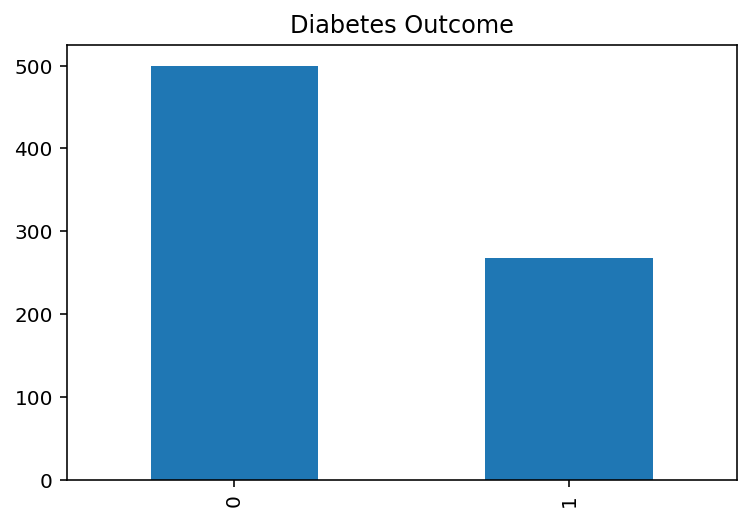

In [7]:
print(df.Outcome.value_counts())
df['Outcome'].value_counts().plot(kind='bar').set_title('Diabetes Outcome')

In [8]:
features = df.drop(columns=['Outcome']).columns.tolist()
features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

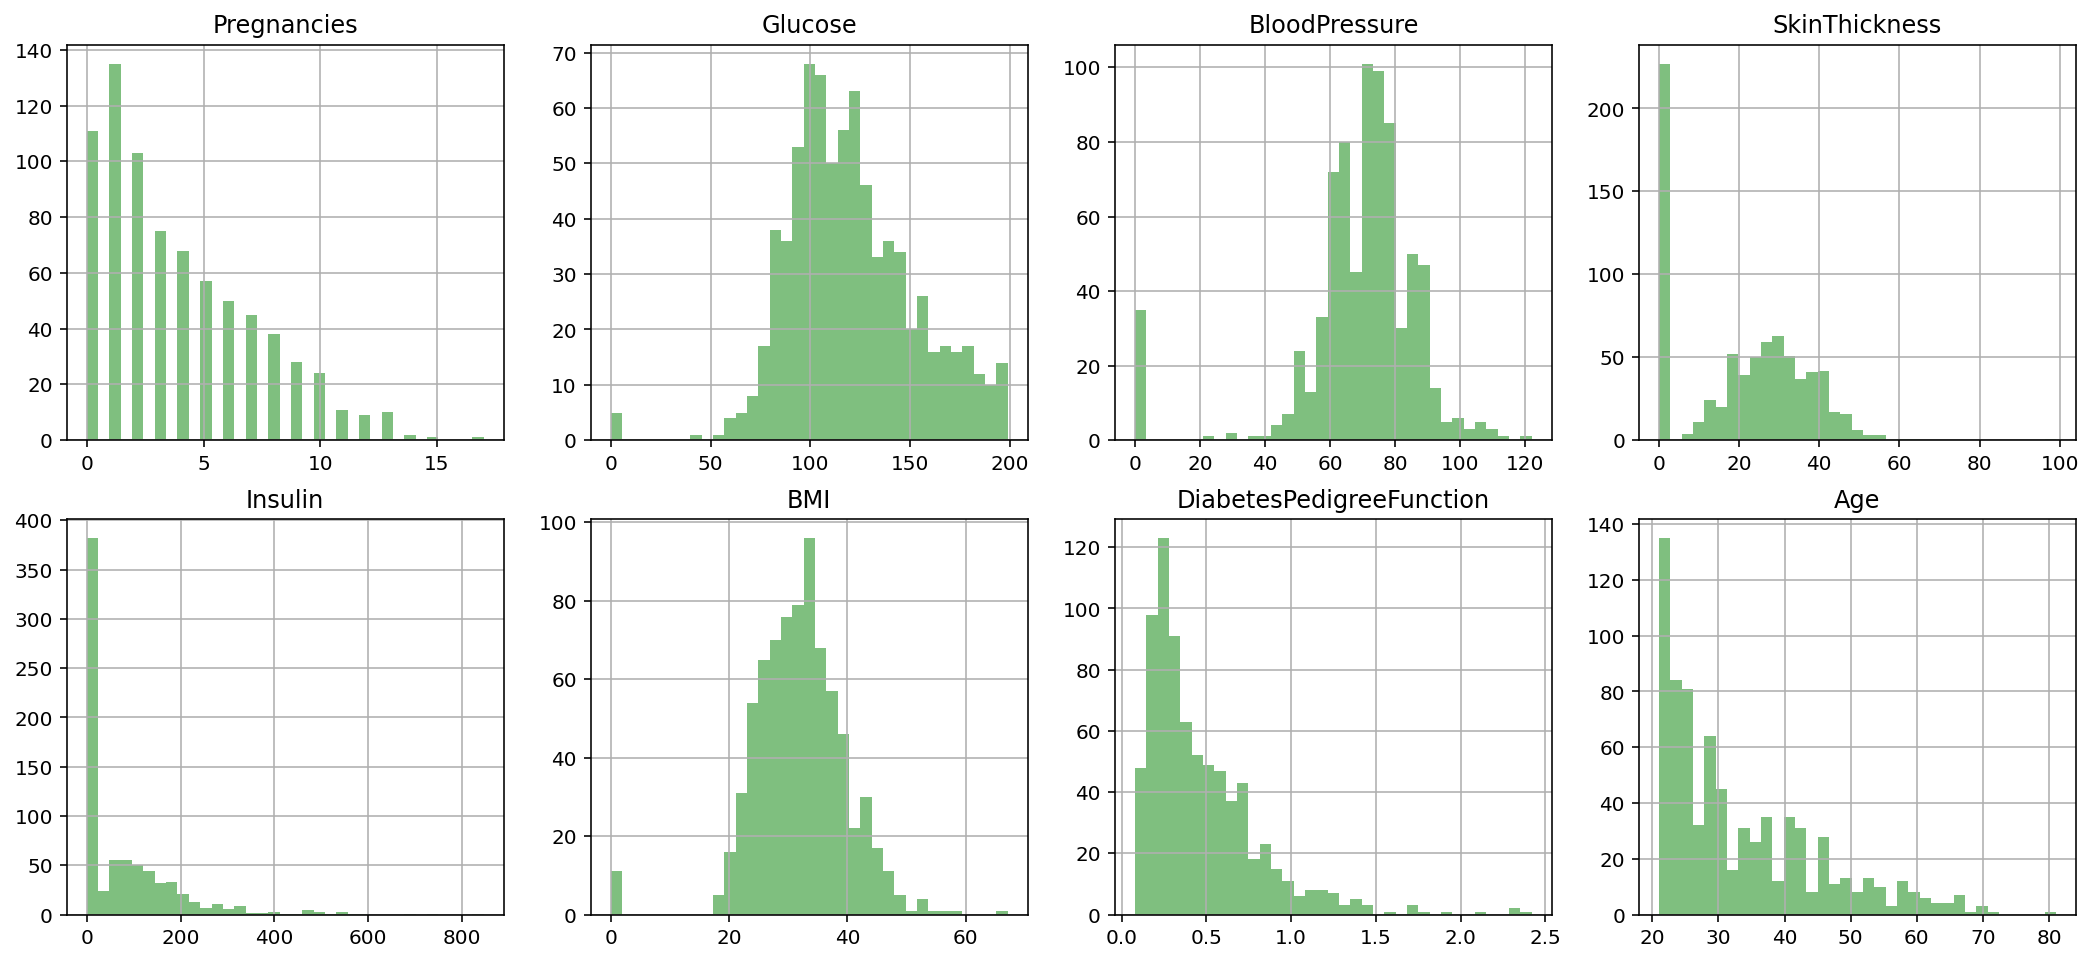

In [9]:
# Visiualize the distribution of our Data.
ROWS, COLS = 2, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8) )
row, col = 0, 0

for i, feature in enumerate(features):
    
    if col == COLS - 1:
        row += 1
    col = i % COLS
    
    df[feature].hist(bins=35, color='green', alpha=0.5, ax=ax[row, col]).set_title(feature)  

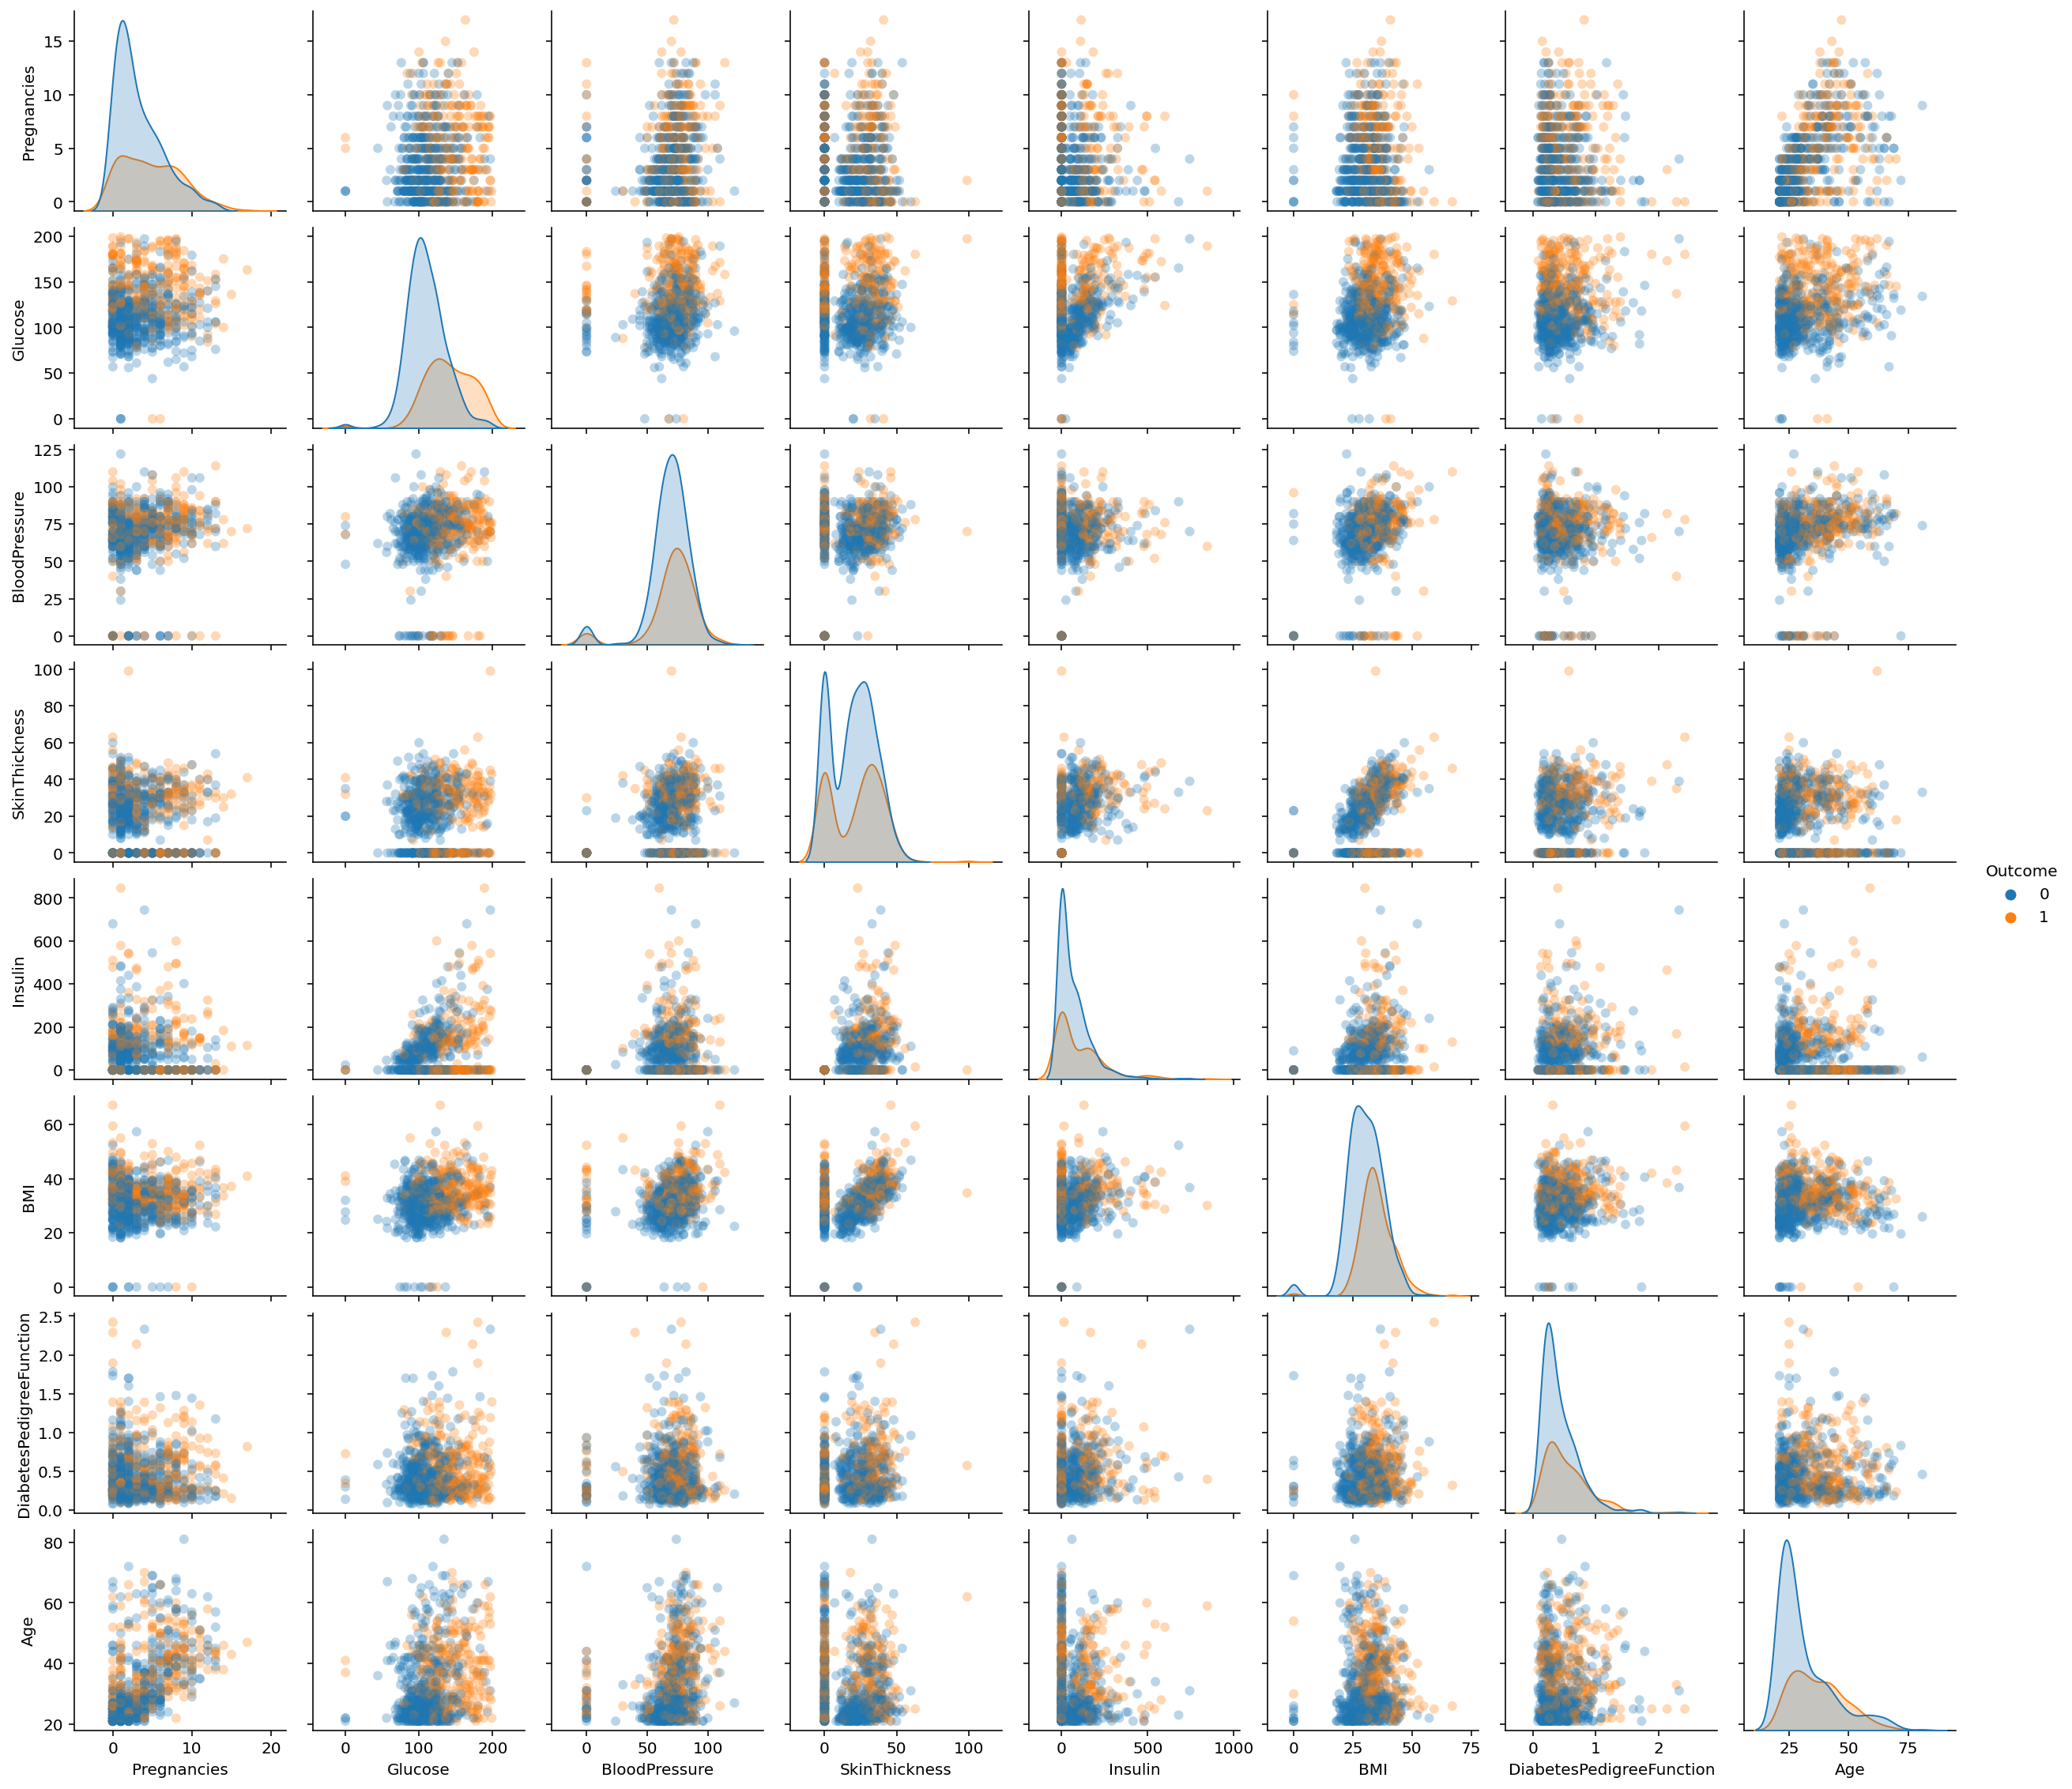

In [10]:
# to visualise pair plot
sns.pairplot(df, hue='Outcome', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

(9.5, -0.5)

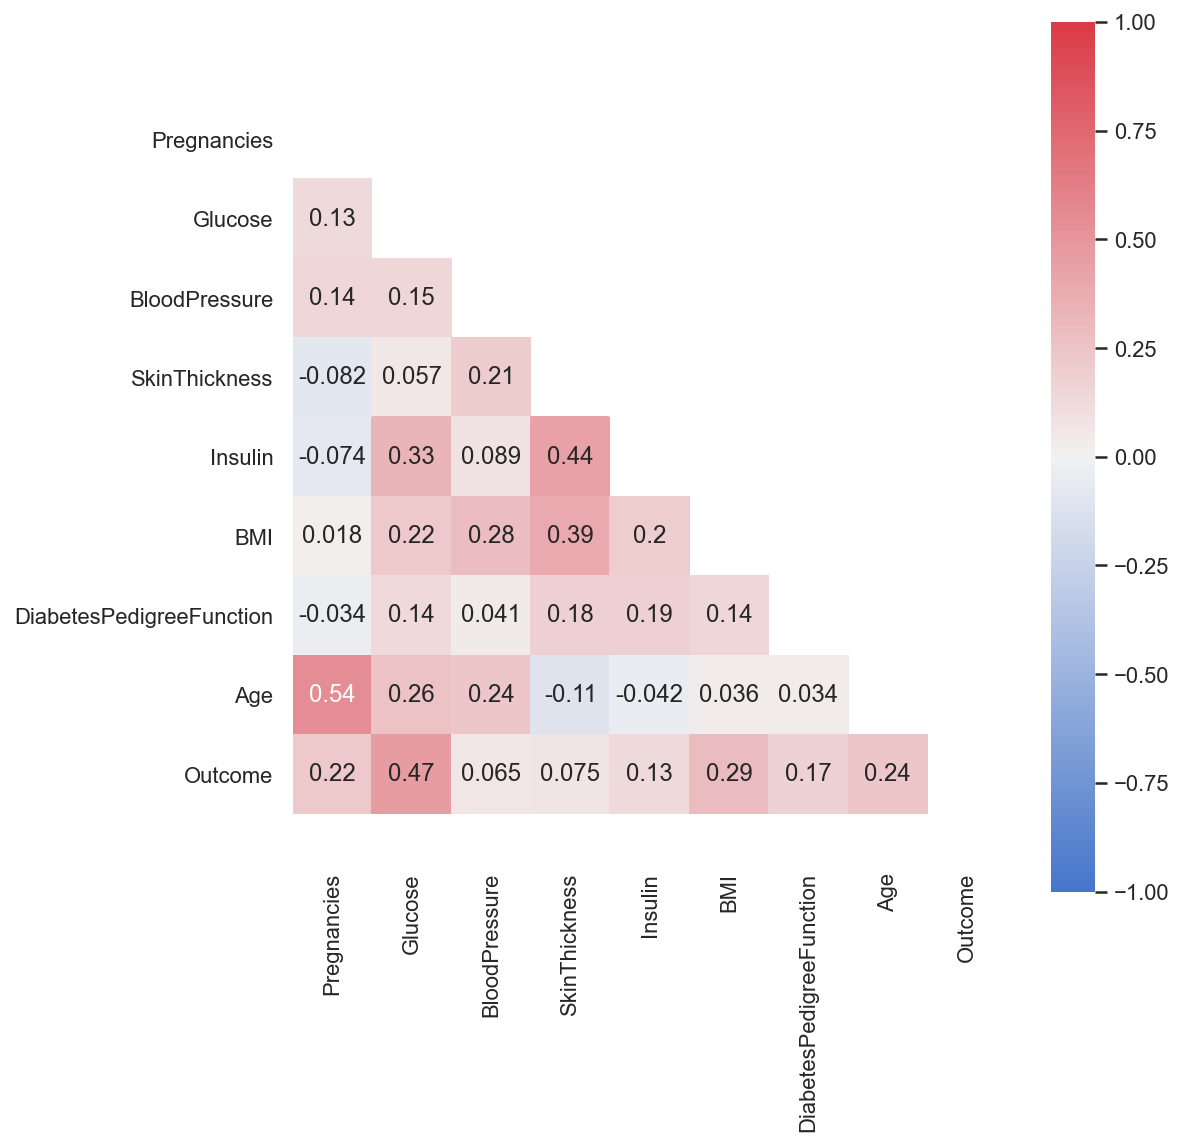

In [11]:
# Correlation Matrix Heatmap Visualization (should run this code again after removing outliers/zero values)
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(8,8))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(df.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

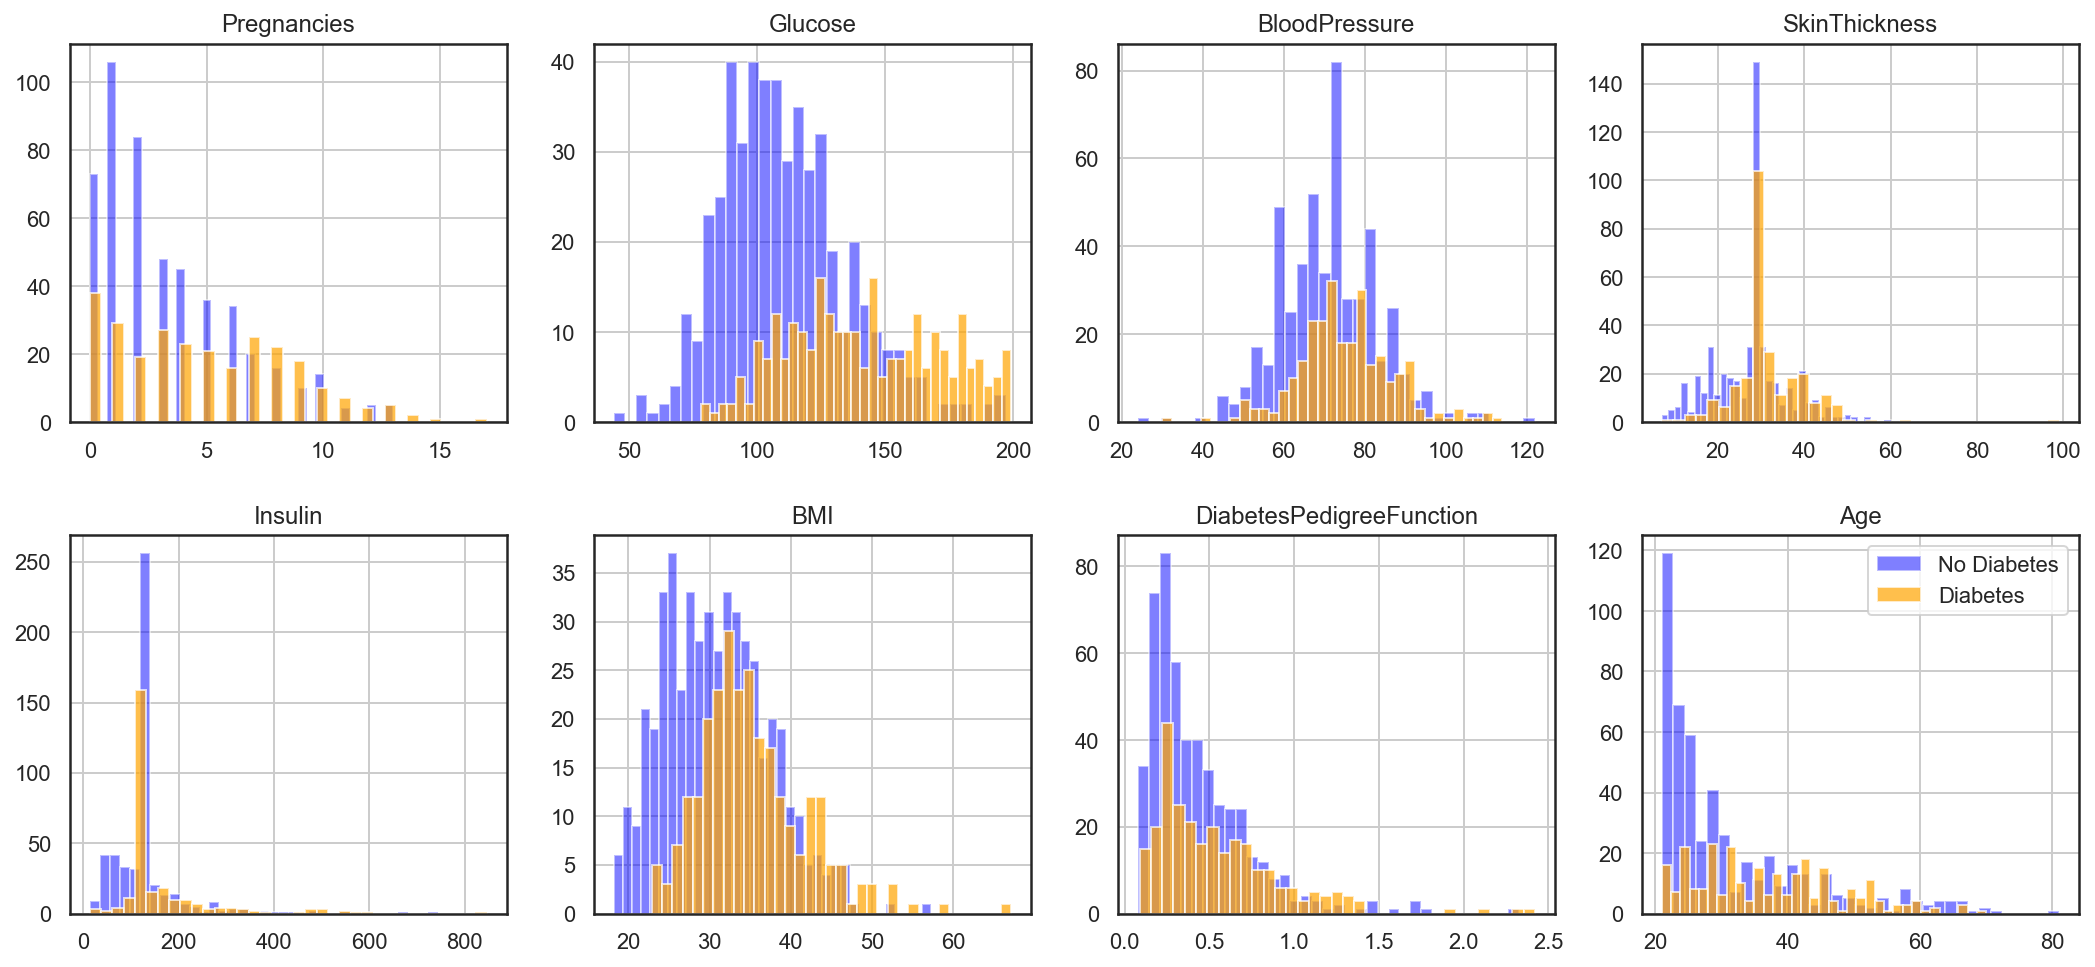

In [16]:
# To analyse feature-outcome distribution in visualisation

features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

ROWS, COLS = 2, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18,8) )
row, col = 0, 0
for i, feature in enumerate(features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    

    df[df.Outcome==0][feature].hist(bins=35, color='blue', alpha=0.5, ax=ax[row, col]).set_title(feature)
    df[df.Outcome==1][feature].hist(bins=35, color='orange', alpha=0.7, ax=ax[row, col])
    
plt.legend(['No Diabetes', 'Diabetes'])
fig.subplots_adjust(hspace=0.3)

In [17]:
# there are zero values in Glucose, BloodPressure, SkinThickness, Insulin, BMI
# need to replace zero by median, 2 steps: replace 0 by NaN, then replace NaN by median (so that 0 will not affect median)
# after this step, run previous visualisation again

df.Glucose.replace(0, np.nan, inplace=True)
df.Glucose.replace(np.nan, df['Glucose'].median(), inplace=True)
df.BloodPressure.replace(0, np.nan, inplace=True)
df.BloodPressure.replace(np.nan, df['BloodPressure'].median(), inplace=True)
df.SkinThickness.replace(0, np.nan, inplace=True)
df.SkinThickness.replace(np.nan, df['SkinThickness'].median(), inplace=True)
df.Insulin.replace(0, np.nan, inplace=True)
df.Insulin.replace(np.nan, df['Insulin'].median(), inplace=True)
df.BMI.replace(0, np.nan, inplace=True)
df.BMI.replace(np.nan, df['BMI'].median(), inplace=True)

Text(0.5, 1.0, 'Top Features derived by Random Forest')

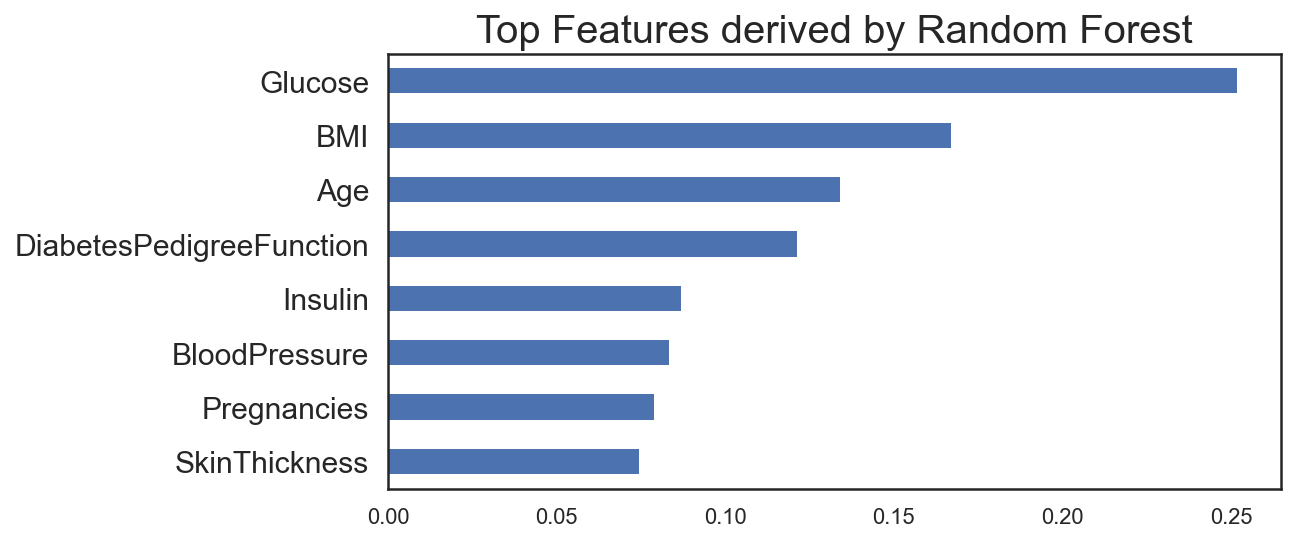

In [18]:
from sklearn.model_selection import train_test_split

X, y = df.drop('Outcome', axis =1), df['Outcome']

rfc = RandomForestClassifier(random_state=SEED, n_estimators=100)
rfc.fit(X, y)

(pd.Series(rfc.feature_importances_, index=X.columns)
    .nlargest(8)
    .plot(kind='barh', figsize=[8,4])
    .invert_yaxis())

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)



In [21]:
# Visualize the Data using t-SNE.

# First we import the library and choose the number of dimensions
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3,perplexity=50)

# first we perform mean normalization
X_centered = X - X.mean(axis=0)

X_centered = np.asarray(X_centered)

# Here we perform the t-SNE
X_tsne = tsne.fit_transform(X_centered)




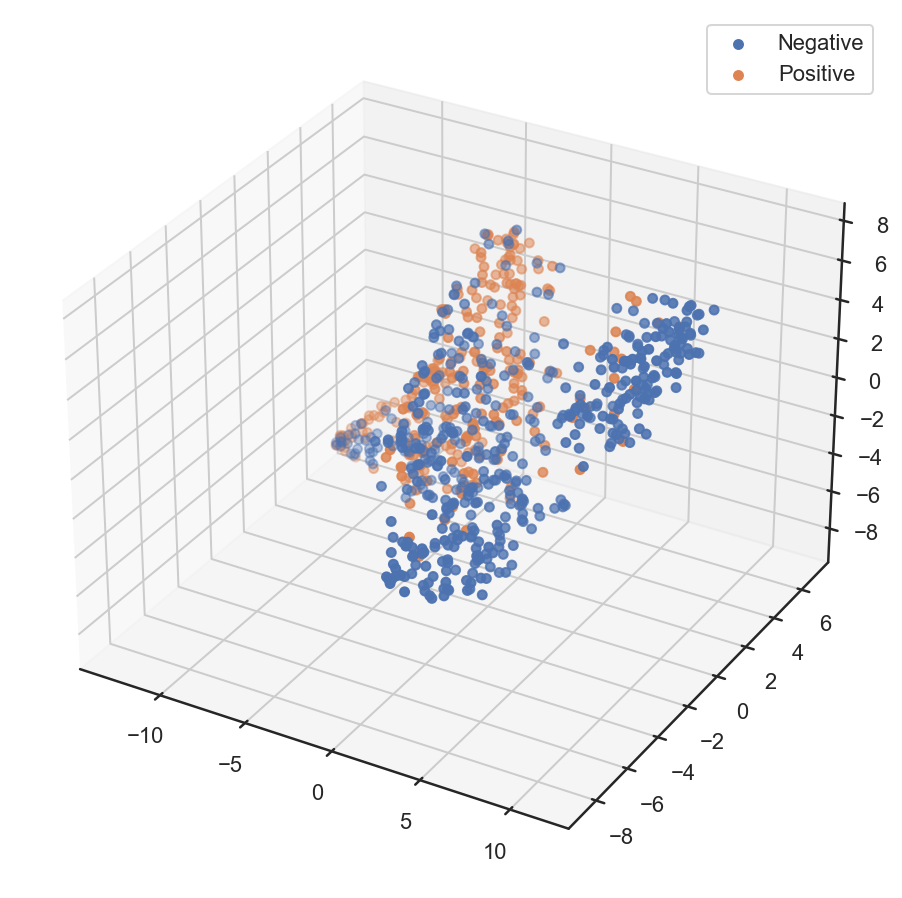

In [22]:
# Let's create a 3d-plot

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

labels = {0: "Negative", 1:"Positive"}

# Let's create a 3d-plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

for i in np.unique(y):
    ax.scatter(X_tsne[y == i][:, 0], 
               X_tsne[y == i][:, 1], 
               X_tsne[y == i][:, 2], 
               s=20, 
               label=labels[i])

plt.legend()

plt.show()

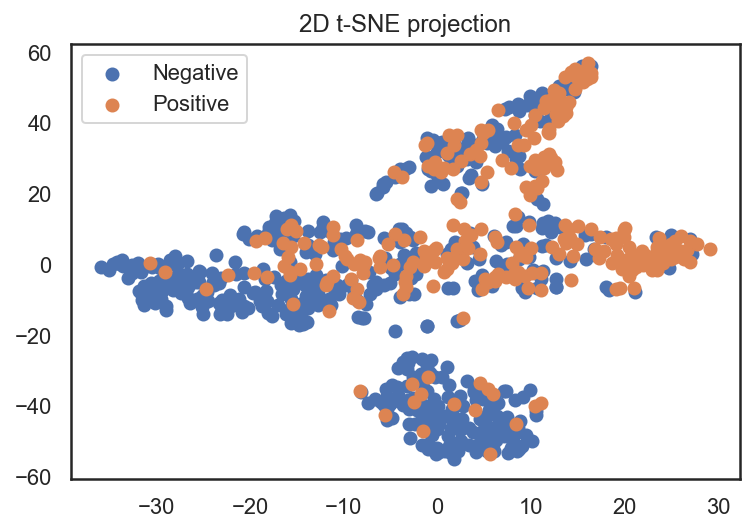

In [23]:
# 2D
tsne = TSNE(n_components=2)

# Here we perform the t-SNE
X_tsne = tsne.fit_transform(X_centered)

# Then we plot the results of t-SNE in 2D
plt.figure()

for i in np.unique(y):
    plt.scatter(X_tsne[y == i][:, 0], X_tsne[y == i][:, 1], label=labels[i])
    
# plt.axis('equal')
plt.legend()
plt.title('2D t-SNE projection')

plt.show()

Use LassoCV to find the optimal ALPHA value for L1 regularization
X_scaled (768, 8)
LASSO best alpha:  0.008603464416684501
[('Glucose', 0.1880413802244648), ('BMI', 0.08931918266428746), ('Pregnancies', 0.06311584122142201), ('DiabetesPedigreeFunction', 0.036276542515315036), ('Age', 0.016956407714825757), ('BloodPressure', -0.0), ('SkinThickness', 0.0), ('Insulin', -0.0)]


Text(0.5, 1.0, 'Top Features derived by LassoCV')

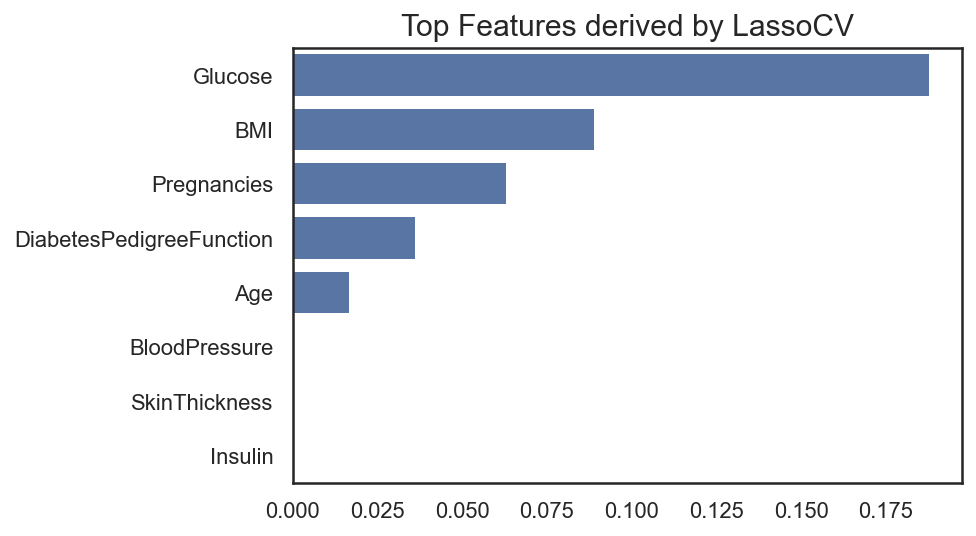

In [24]:
## to find significant features using LassoCV (all X_scaled)
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

print('Use LassoCV to find the optimal ALPHA value for L1 regularization')
# Scale the Predictors on both the train and validation set
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
print('X_scaled', X_scaled.shape)

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
# This is the best alpha value found
print('LASSO best alpha: ', lasso_model.alpha_ )

# display all coefficients in the model with optimal alpha
zipped = list(zip(X.columns, lasso_model.coef_)) 
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
print(zipped)
a,b = zip(*zipped)
sns.barplot(y=list(a), x=list(b), color='b')
plt.title('Top Features derived by LassoCV', size=15)

In [25]:
# for linear data and model, p-value < 0.05 indicates a significant feature
import statsmodels.api as sm
X = sm.add_constant(X) 

# model / fit / summarize results
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     44.90
Date:                Wed, 18 Nov 2020   Prob (F-statistic):           4.25e-59
Time:                        12:17:25   Log-Likelihood:                -371.86
No. Observations:                 768   AIC:                             761.7
Df Residuals:                     759   BIC:                             803.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.0237      0.104     -9.841      0.000      -1.228      -0.819
Pregnancies                  0.0206      0.005      4.074      0.000       0.011       0.031
Glucose                      0.0065      0.001     11.967      0.000       0.005       0.008
BloodPressure               -0.0012      0.001     -0.924      0.356      -0.004       0.001
SkinThickness                0.0002      0.002      0.098      0.922      -0.004       0.004
Insulin                     -0.0002      0.000     -0.850      0.396      -0.001       0.000
BMI                          0.0145      0.003      5.574      0.000       0.009       0.020
DiabetesPedigreeFunction     0.1306      0.044      2.963      0.003       0.044       0.217
Age                          0.0021      0.002      1.355      0.176      -0.001       0.005
==============================================================================
Omnibus:                       33.680   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.901
Skew:                           0.322   Prob(JB):                     6.46e-06
Kurtosis:                       2.424   Cond. No.                     1.60e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3) Split & Model Selection

Specify stratify parameter to make a split so that the proportion of values in the splitted dataset produced will have the same proprotion as the stratify column provided.

For example, if variable y is a binary categorical class with values 0 and 1 and there are 25% of '0's and 75% of '1's, stratify=y will make sure that your random split has 25% of 
'0's and 75% of '1's in both splitted dataset.


In [26]:
X = df.drop('Outcome', axis=1)   # axis=0 for row, axis=1 for column
y = df['Outcome']

# split data to 80:20 ratio for train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)


X_train (614, 8)
y_train (614,)
X_test (154, 8)
y_test (154,)


#### Cross Validation
Use StratifiedKFold, especially if target class is imbalance

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

In [27]:
## Baseline model performance evaluation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# to give model baseline report in dataframe 
def baseline_report(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc'))
    y_pred = model.predict(X_test)
    logloss      = log_loss(y_test, y_pred)   # SVC & LinearSVC unable to use cvs

    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [0]       })   # timetaken: to be used for comparison later
    return df_model

# to evaluate baseline models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
svc = SVC()
linearsvc = LinearSVC()

# to concat all models
df_models = pd.concat([baseline_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB'),
                       baseline_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB'),
                       baseline_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB'),
                       baseline_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression'),
                       baseline_report(knn, X_train, X_test, y_train, y_test, 'KNN'),
                       baseline_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree'),
                       baseline_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest'),
                       baseline_report(svc, X_train, X_test, y_train, y_test, 'SVC'),
                       baseline_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')
                       ], axis=0).reset_index()
df_models = df_models.drop('index', axis=1)
df_models

model  accuracy  precision    recall   f1score    rocauc  \
0          GaussianNB  0.745942   0.645770  0.588704  0.612958  0.818630   
1         BernoulliNB  0.651473   0.000000  0.000000  0.000000  0.473707   
2       MultinomialNB  0.646541   0.492421  0.406755  0.441561  0.651794   
3  LogisticRegression  0.767146   0.714637  0.551274  0.618351  0.829802   
4                 KNN  0.728122   0.614779  0.593798  0.603451  0.758839   
5        DecisionTree  0.710129   0.567700  0.607973  0.587965  0.677745   
6        RandomForest  0.747568   0.683614  0.583942  0.608347  0.821602   
7                 SVC  0.765480   0.754007  0.481285  0.582467  0.818861   
8           LinearSVC  0.530934   0.215126  0.581395  0.156410  0.736319   

     logloss  timetaken  
0   8.522638          0  
1  12.111000          0  
2  10.092603          0  
3   8.298350          0  
4   9.195482          0  
5  12.111124          0  
6   8.746911          0  
7   8.522607          0  
8  11.213899          0

#### Step 5: Optimise model: hyperparameter tuning

In [28]:
def model_report(model, X_train, X_test, y_train, y_test, model_name):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                 
        for th in th_list[i]:
            if th<0: 
                score_list.append(-1)
                continue
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred)
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display f1score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    accuracy      = model.score(X_test, y_test)
    print('Test set: {:.2f}%'.format(100*accuracy))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
#     y_pred = [1 if x==True else 0 if x==False else x for x in y_pred]   # .predict->0/1; .predict_proba->False/True
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    precision    = precision_score(y_test, y_pred)
    recall       = recall_score(y_test, y_pred)
    f1score      = f1_score(y_test, y_pred)
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(precision, recall, f1score))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    y_pred = model.predict_proba(X_test)[:,1]   # use this at optimal th, for AUC and logloss
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    rocauc       = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(rocauc))
    logloss      = log_loss(y_test, y_pred)   # same result using y_pred = model.predict_proba(X_test)
    print(model_name, 'Log-loss: {:.4f}'.format(logloss))

    df_model = pd.DataFrame({'model'        : [model_name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'logloss'      : [logloss],
                             'timetaken'    : [1000]       })   # timetaken for comparison later
    return df_model

In [29]:
print('\n"""""" GaussianNB """"""')
time1 = time.time()
gnb = GaussianNB()
model1 = model_report(gnb, X_train, X_test, y_train, y_test, 'GaussianNB')
model1.timetaken[0] = time.time() - time1


print('\n"""""" BernoulliNB """"""')
time1 = time.time()
bnb = BernoulliNB()
model2 = model_report(bnb, X_train, X_test, y_train, y_test, 'BernoulliNB')
model2.timetaken[0] = time.time() - time1


print('\n"""""" MultinomialNB """"""')
time1 = time.time()
mnb = MultinomialNB()
model3 = model_report(mnb, X_train, X_test, y_train, y_test, 'MultinomialNB')
model3.timetaken[0] = time.time() - time1


"""""" GaussianNB """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.6331,  0.200->0.6341,  0.300->0.6195,  0.400->0.6542,  0.500->0.6275,  0.600->0.6122,  0.700->0.5581,  0.800->0.5000,  0.900->0.3380,  1.000->0.0364,  
Looping decimal place 2
0.300->0.6195,  0.310->0.6250,  0.320->0.6250,  0.330->0.6306,  0.340->0.6306,  0.350->0.6422,  0.360->0.6422,  0.370->0.6481,  0.380->0.6481,  0.390->0.6481,  0.400->0.6542,  0.410->0.6476,  0.420->0.6476,  0.430->0.6476,  0.440->0.6476,  0.450->0.6476,  0.460->0.6476,  0.470->0.6346,  0.480->0.6346,  0.490->0.6214,  0.500->0.6275,  
Looping decimal place 3
0.390->0.6481,  0.391->0.6481,  0.392->0.6481,  0.393->0.6542,  0.394->0.6542,  0.395->0.6542,  0.396->0.6542,  0.397->0.6542,  0.398->0.6542,  0.399->0.6542,  0.400->0.6542,  0.401->0.6415,  0.402->0.6415,  0.403->0.6415,  0.404->0.6476,  0.405->0.6476,  0.406->0.6476,  0.407->0.6476,  0.408->0.

In [30]:
print('\n"""""" LogisticRegression """"""')
time1 = time.time()
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

logit = LogisticRegression(C = optimal_c)
model4 = model_report(logit, X_train, X_test, y_train, y_test, 'LogisticRegression')
model4.timetaken[0] = time.time() - time1


"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.6306, 0.6219, 0.6260, 0.6260, 0.6219, 0.6301, 0.6316, 0.6141, 0.6270, 0.6333, 0.6301, 0.6125, 0.6325, 0.6307, 0.6220, 0.6112, 0.6277, 0.6305, 0.6227, 0.6353, 0.6395, 0.6026, 0.6184, 0.6372, 0.6155, 0.6212, 0.6380, 0.6373, 0.6264, 0.6236, 0.6389, 0.6136, 0.6063, 0.6142, 0.6411, 0.6418, 0.6345, 0.6287, 0.6264, 0.6307, 0.6365, 0.6123, 0.6201, 0.6283, 0.6255, 0.6189, 0.6097, 0.6354, 0.6356, 0.6206, 0.6353, 0.6151, 0.6085, 0.6306, 0.6305, 0.6322, 0.6186, 0.6174, 0.6302, 0.6320, 0.6229, 0.6283, 0.6365, 0.6270, 0.6342, 0.6279, 0.6281, 0.6466, 0.6327, 0.6442, 0.6340, 0.6320, 0.6413, 0.6340, 0.6436, 0.6396, 0.6363, 0.6362, 0.6358, 0.6424, 0.6447, 0.6471, 0.6394, 0.6342, 0.6459, 0.6422, 0.6419, 0.6356, 0.6405, 0.6573, 0.6508, 0.6475, 0.6462, 0.6515, 0.6533, 0.6459, 0.6475, 0.6421, 0.6480, 0.6475, 0.6430, 0.6370, 0.6406, 0.6380, 

In [31]:
print('\n"""""" KNN """""" ')
time1 = time.time()
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

knn = KNeighborsClassifier(n_neighbors = optimal_k)
model5 = model_report(knn, X_train, X_test, y_train, y_test, 'KNN')
model5.timetaken[0] = time.time() - time1

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))


"""""" KNN """""" 

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.5235, 0.4388, 0.5591, 0.5437, 0.5813, 0.5615, 0.6030, 0.5732, 0.5672, 0.5551, 0.5946, 0.5582, 0.5899, 0.5462, 0.5879, 0.5526, 0.5773, 0.5542, 0.5742, 0.5583, optimal cv F1 score = 0.6030
optimal value of K = 7

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5829,  0.100->0.5829,  0.200->0.6164,  0.300->0.6167,  0.400->0.6167,  0.500->0.6604,  0.600->0.5517,  0.700->0.5517,  0.800->0.4384,  0.900->0.1379,  1.000->0.1379,  
Looping decimal place 2
0.400->0.6167,  0.410->0.6167,  0.420->0.6167,  0.430->0.6604,  0.440->0.6604,  0.450->0.6604,  0.460->0.6604,  0.470->0.6604,  0.480->0.6604,  0.490->0.6604,  0.500->0.6604,  0.510->0.6604,  0.520->0.6604,  0.530->0.6604,  0.540->0.6604,  0.550->0.6604,  0.560->0.6604,  0.570->0.6604,  0.580->0.5517,  0.590->0.5517,  0.600->0.5517,  
Loo

In [32]:
print('\n"""""" DecisionTreeClassifier """"""')
time1 = time.time()
print('\nSearch for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
d_scores = []
for d in range(2, 11):
    decisiontree = DecisionTreeClassifier(max_depth=d)
    cvs = cross_val_score(decisiontree, X_train, y_train, cv=kf, scoring='f1').mean()
    d_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal F1 score = {:.4f}'.format(max(d_scores)))   # 4 decimal pl
optimal_d = d_scores.index(max(d_scores))+2   # index 0 is for d=2
print('optimal max_depth =', optimal_d)

decisiontree = DecisionTreeClassifier(max_depth=optimal_d)
model6 = model_report(decisiontree, X_train, X_test, y_train, y_test, 'DecisionTree')
model6.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" DecisionTreeClassifier """"""

Search for optimal max_depth in DecisionTree, vary 2 to 10, using KFold(5) Cross Validation on train data
0.5799, 0.5513, 0.6080, 0.5953, 0.5943, 0.5812, 0.5939, 0.5797, 0.5795, optimal F1 score = 0.6080
optimal max_depth = 4

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5698,  0.100->0.5814,  0.200->0.6560,  0.300->0.6560,  0.400->0.6325,  0.500->0.6325,  0.600->0.4762,  0.700->0.4000,  0.800->0.4000,  0.900->0.4000,  1.000->0.0000,  
Looping decimal place 2
0.100->0.5814,  0.110->0.5814,  0.120->0.5952,  0.130->0.5952,  0.140->0.6560,  0.150->0.6560,  0.160->0.6560,  0.170->0.6560,  0.180->0.6560,  0.190->0.6560,  0.200->0.6560,  0.210->0.6560,  0.220->0.6560,  0.230->0.6560,  0.240->0.6560,  0.250->0.6560,  0.260->0.6560,  0.270->0.6560,  0.280->0.6560,  0.290->0.6560,  0.300->0.6560,  
Looping decimal place 3
0.130->0.5952,  0.131->0.5952,  0.132->0.5952,  0.133->0.5

In [33]:
print('\n"""""" RandomForestClassifier """""" (quite slow)')
time1 = time.time()
print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=SEED, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

randomforest = RandomForestClassifier(n_estimators=optimal_n)
model7 = model_report(randomforest, X_train, X_test, y_train, y_test, 'RandomForest')
model7.timetaken[0] = time.time() - time1
# Note: results keep changing in each run


"""""" RandomForestClassifier """""" (quite slow)

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.6201, 150->0.6133, 200->0.6166, 250->0.6112, 300->0.6241, 350->0.6219, 400->0.6168, 450->0.6220, 500->0.6252, optimal F1 score = 0.6252
optimal n_estimators = 500

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.6228,  0.200->0.6571,  0.300->0.6970,  0.400->0.6838,  0.500->0.6400,  0.600->0.4884,  0.700->0.3889,  0.800->0.2000,  0.900->0.0000,  1.000->0.0000,  
Looping decimal place 2
0.200->0.6571,  0.210->0.6619,  0.220->0.6667,  0.230->0.6715,  0.240->0.6715,  0.250->0.6765,  0.260->0.6815,  0.270->0.6866,  0.280->0.6866,  0.290->0.6866,  0.300->0.6970,  0.310->0.7023,  0.320->0.6923,  0.330->0.6822,  0.340->0.6875,  0.350->0.6992,  0.360->0.6942,  0.370->0.6942,  0.380->0.6891,  0.390->0.6891,  0.400->0.6838,  
Looping decim

In [34]:
print('\n"""""" SVC """"""')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model8 = model_report(svc, X_train, X_test, y_train, y_test, 'SVC')
model8.timetaken[0] = time.time() - time1



"""""" SVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.5192,  0.100->0.5761,  0.200->0.6809,  0.300->0.6034,  0.400->0.5660,  0.500->0.5833,  0.600->0.5455,  0.700->0.4810,  0.800->0.3188,  0.900->0.1017,  1.000->0.0000,  
Looping decimal place 2
0.100->0.5761,  0.110->0.5889,  0.120->0.6163,  0.130->0.6386,  0.140->0.6420,  0.150->0.6581,  0.160->0.6667,  0.170->0.6755,  0.180->0.6849,  0.190->0.6853,  0.200->0.6809,  0.210->0.6857,  0.220->0.6812,  0.230->0.6767,  0.240->0.6818,  0.250->0.6562,  0.260->0.6400,  0.270->0.6281,  0.280->0.6167,  0.290->0.6154,  0.300->0.6034,  
Looping decimal place 3
0.200->0.6809,  0.201->0.6809,  0.202->0.6857,  0.203->0.6857,  0.204->0.6857,  0.205->0.6857,  0.206->0.6857,  0.207->0.6857,  0.208->0.6857,  0.209->0.6857,  0.210->0.6857,  0.211->0.6857,  0.212->0.6857,  0.213->0.6857,  0.214->0.6857,  0.215->0.6763,  0.216->0.6763,  0.217->0.6763,  0.218->0.6812,  

In [35]:
print('\n"""""" LinearSVC """"""')
time1 = time.time()
linearsvc = LinearSVC()
# model9 = model_report(linearsvc, X_train, X_test, y_train, y_test, 'LinearSVC')   # model has no attribute 'predict_proba'

linearsvc.fit(X_train, y_train)
print('LinearSVC accuracy score is')
print('Training: {:.2f}%'.format(100*linearsvc.score(X_train, y_train)))  # score uses accuracy
accuracy      = linearsvc.score(X_test, y_test)
print('Test set: {:.2f}%'.format(100*accuracy))

y_pred = linearsvc.predict(X_test)
print(classification_report(y_test, y_pred))
print('LinearSVC confusion matrix: \n', confusion_matrix(y_test, y_pred))

precision    = precision_score(y_test, y_pred)
recall       = recall_score(y_test, y_pred)
f1score      = f1_score(y_test, y_pred) 
rocauc       = roc_auc_score(y_test, y_pred)
logloss      = log_loss(y_test, y_pred)
print('LinearSVC AUC: {:.4f}'.format(rocauc))
print('LinearSVC Log-loss: {:.4f}'.format(logloss))

model9 = pd.DataFrame({'model'        : ['LinearSVC'],
                       'accuracy'     : [accuracy],
                       'precision'    : [precision],
                       'recall'       : [recall],
                       'f1score'      : [f1score],
                       'rocauc'       : [rocauc],
                       'logloss'      : [logloss],
                       'timetaken'    : [time.time() - time1]       })
# Note: results keep changing in each run


"""""" LinearSVC """"""
LinearSVC accuracy score is
Training: 65.15%
Test set: 64.94%
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154

LinearSVC confusion matrix: 
 [[100   0]
 [ 54   0]]
LinearSVC AUC: 0.5000
LinearSVC Log-loss: 12.1110


In [36]:
# concat all models
df_models_tuned = pd.concat([model1,model2,model3,model4,model5,model6,model7,model8,model9],axis = 0).reset_index()
df_models_tuned.drop('index', axis=1, inplace=True)
df_models_tuned

model  accuracy  precision    recall   f1score    rocauc  \
0          GaussianNB  0.753247   0.660377  0.648148  0.654206  0.803704   
1         BernoulliNB  0.649351   0.350649  1.000000  0.519231  0.481296   
2       MultinomialNB  0.707792   0.544118  0.685185  0.606557  0.744259   
3  LogisticRegression  0.753247   0.564706  0.888889  0.690647  0.823519   
4                 KNN  0.766234   0.673077  0.648148  0.660377  0.784259   
5        DecisionTree  0.720779   0.577465  0.759259  0.656000  0.765278   
6        RandomForest  0.766234   0.597403  0.851852  0.702290  0.822593   
7                 SVC  0.753247   0.558140  0.888889  0.685714  0.811111   
8           LinearSVC  0.649351   0.000000  0.000000  0.000000  0.500000   

     logloss  timetaken  
0   0.595745   0.000000  
1   0.648316   0.000000  
2   0.830339   0.000000  
3   0.489812  28.000000  
4   1.130882   1.000000  
5   1.177166   0.000000  
6   0.486187  28.000000  
7   0.523696   0.000000  
8  12.111000   0.042859

In [37]:
df_models   

model  accuracy  precision    recall   f1score    rocauc  \
0          GaussianNB  0.745942   0.645770  0.588704  0.612958  0.818630   
1         BernoulliNB  0.651473   0.000000  0.000000  0.000000  0.473707   
2       MultinomialNB  0.646541   0.492421  0.406755  0.441561  0.651794   
3  LogisticRegression  0.767146   0.714637  0.551274  0.618351  0.829802   
4                 KNN  0.728122   0.614779  0.593798  0.603451  0.758839   
5        DecisionTree  0.710129   0.567700  0.607973  0.587965  0.677745   
6        RandomForest  0.747568   0.683614  0.583942  0.608347  0.821602   
7                 SVC  0.765480   0.754007  0.481285  0.582467  0.818861   
8           LinearSVC  0.530934   0.215126  0.581395  0.156410  0.736319   

     logloss  timetaken  
0   8.522638          0  
1  12.111000          0  
2  10.092603          0  
3   8.298350          0  
4   9.195482          0  
5  12.111124          0  
6   8.746911          0  
7   8.522607          0  
8  11.213899          0

In [39]:
# initialise an empty df for comparison: 1 = improved, 0 = no improvement

df1 = pd.DataFrame({'model': [0]*9,'accuracy': [0]*9,'precision': [0]*9,'recall': [0]*9,'f1score': [0]*9,'rocauc': [0]*9,'logloss': [0]*9,'timetaken': [0]*9})
df1.model = df_models.model
for i in range(1,6):
    for j in range(9):
        if df_models_tuned[df_models_tuned.columns[i]][j] > df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
for i in range(6,8):
    for j in range(9):
        if df_models_tuned[df_models_tuned.columns[i]][j] < df_models[df_models.columns[i]][j]:
            df1[df1.columns[i]][j] = 1
df1   # Note: F1-Score has improved for all models after tuning the threshold and other hyperparameters

model  accuracy  precision  recall  f1score  rocauc  logloss  \
0          GaussianNB         1          1       1        1       0        1   
1         BernoulliNB         0          1       1        1       1        1   
2       MultinomialNB         1          1       1        1       1        1   
3  LogisticRegression         0          0       1        1       0        1   
4                 KNN         1          1       1        1       1        1   
5        DecisionTree         1          1       1        1       1        1   
6        RandomForest         1          0       1        1       1        1   
7                 SVC         0          0       1        1       0        1   
8           LinearSVC         1          0       0        0       0        0   

   timetaken  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0  
8          0

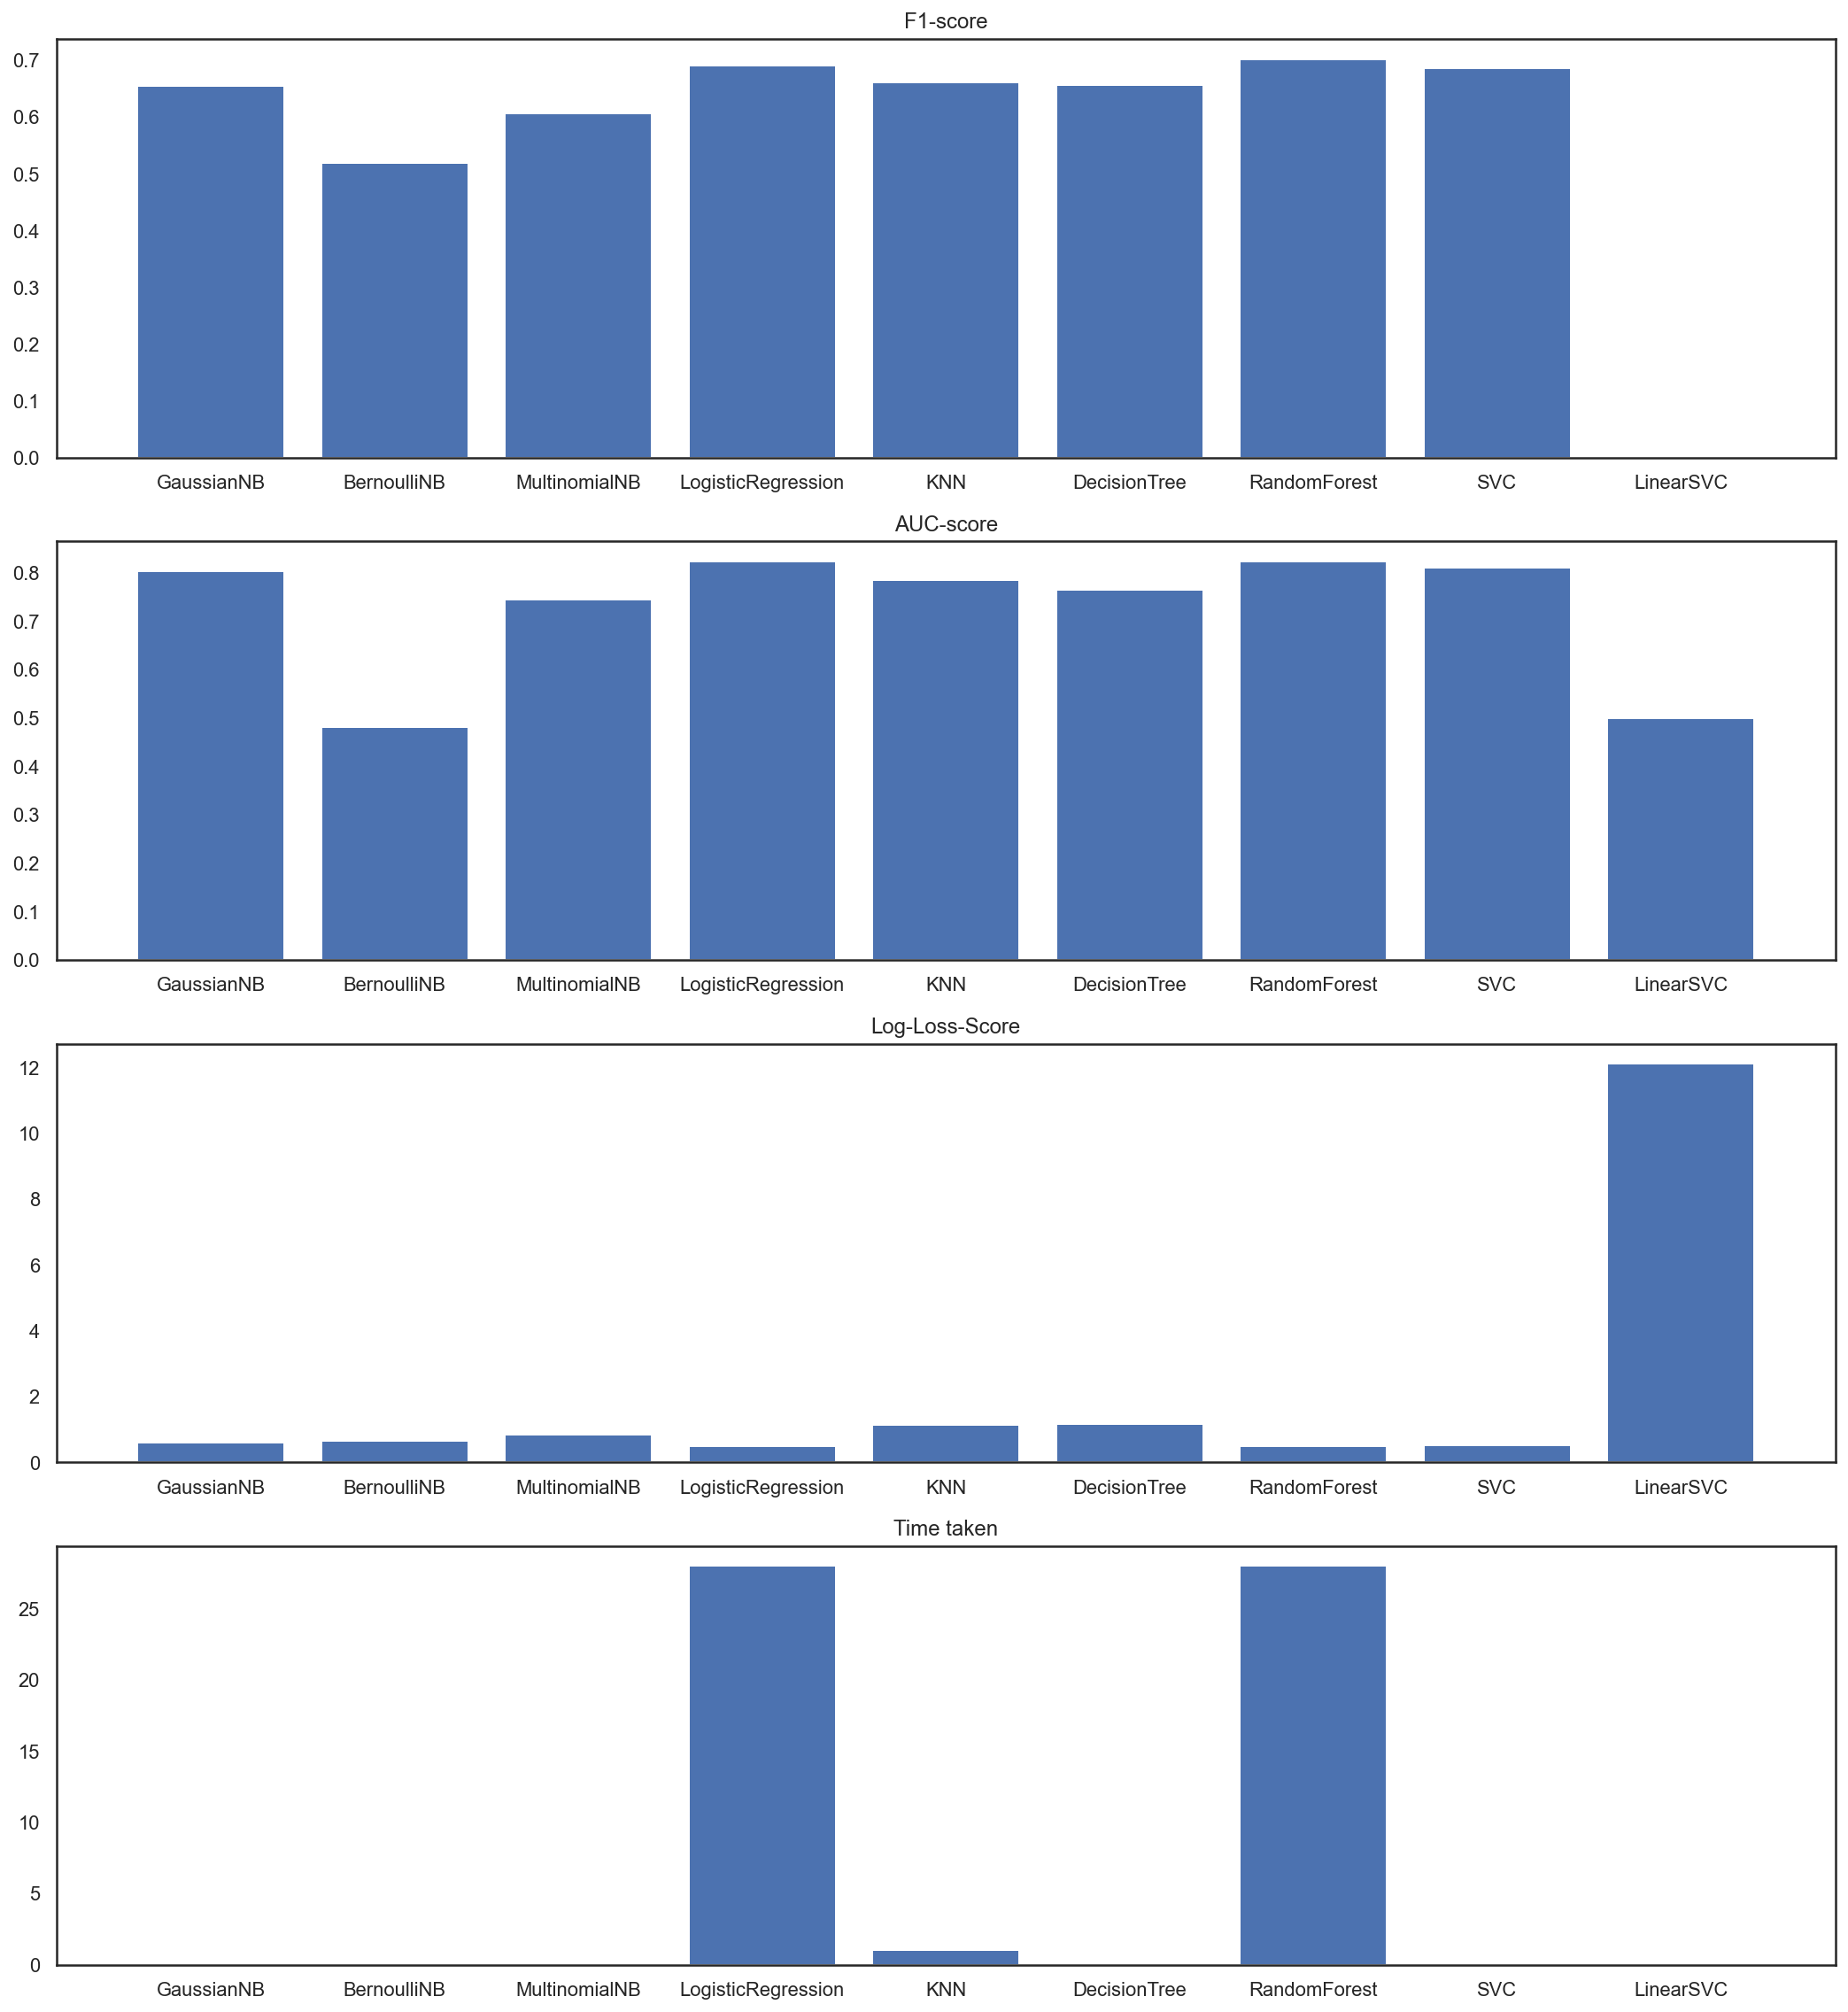

In [40]:
## plot the performance metric scores
fig, ax = plt.subplots(4, 1, figsize=(18, 20))

ax[0].bar(df_models_tuned.model, df_models_tuned.f1score)
ax[0].set_title('F1-score')

ax[1].bar(df_models_tuned.model, df_models_tuned.rocauc)
ax[1].set_title('AUC-score')

ax[2].bar(df_models_tuned.model, df_models_tuned.logloss)
ax[2].set_title('Log-Loss-Score')

ax[3].bar(df_models_tuned.model, df_models_tuned.timetaken)
ax[3].set_title('Time taken')

# Fine-tune figure; make subplots farther from each other, or nearer to each other.
fig.subplots_adjust(hspace=0.2, wspace=0.2)


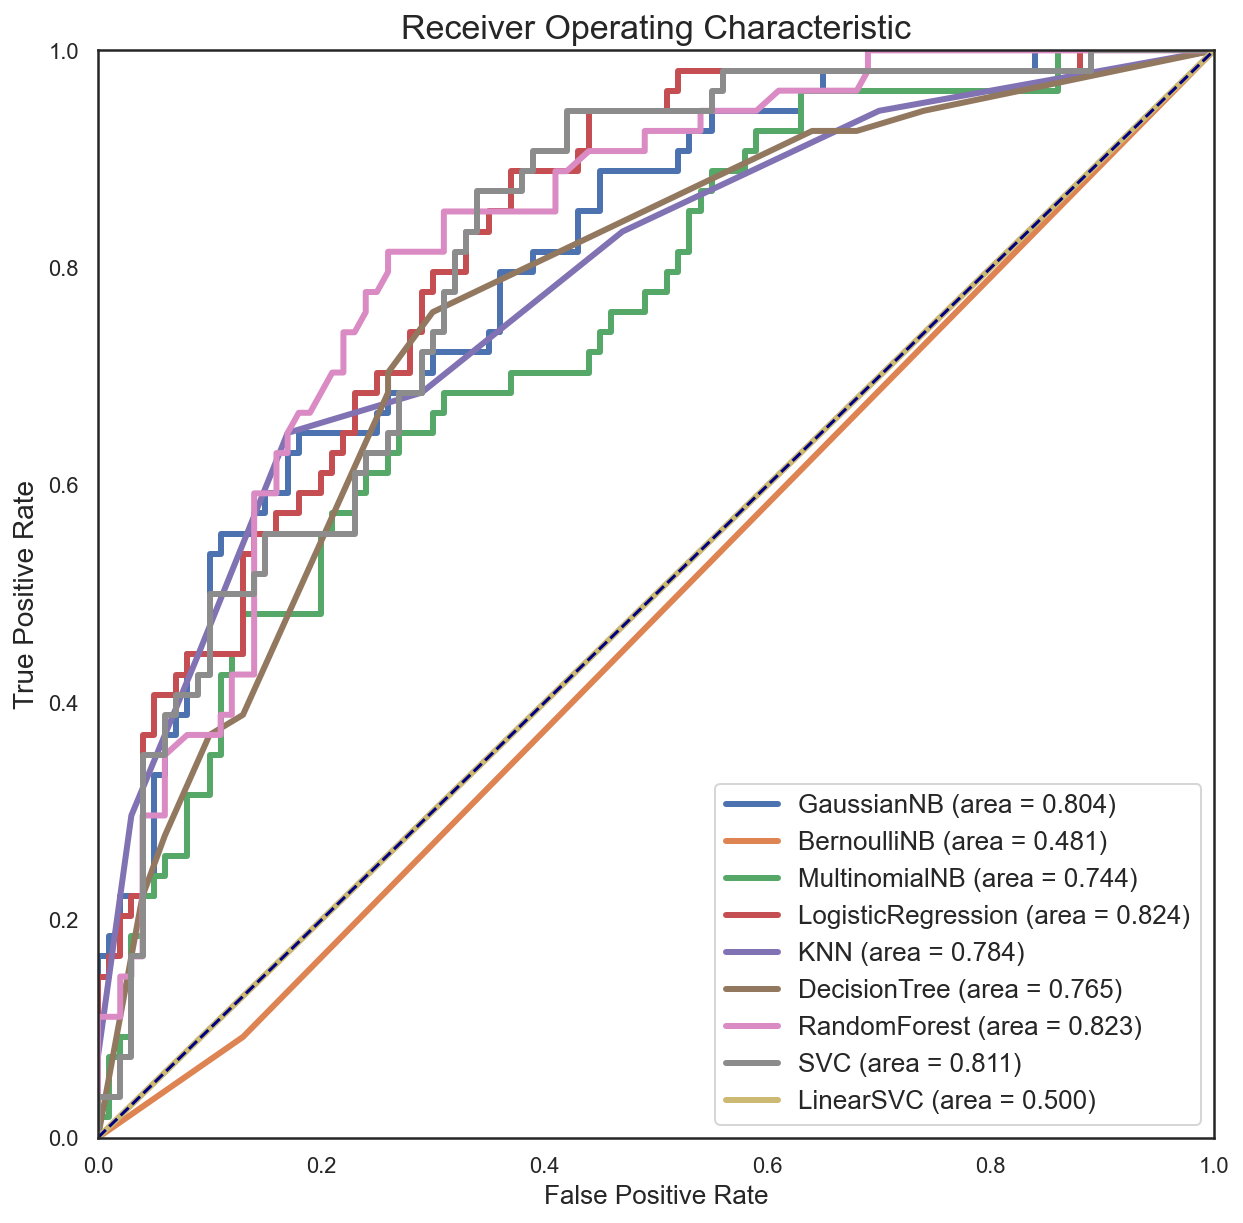

In [41]:
# plot the ROC curves
plt.figure(figsize=(10,10))

model_name = [gnb, bnb, mnb, logit, knn, decisiontree, randomforest, svc, linearsvc]

for i in range(8):
    y_pred = model_name[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, lw=3, label=df_models_tuned.model[i] + ' (area = %0.3f)' % auc(fpr, tpr))

y_pred = linearsvc.predict(X_test)   # linearsvc has no attribute 'predict_proba'
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=3, label='LinearSVC (area = %0.3f)' % auc(fpr, tpr))

plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

In [42]:
# see how model confusion matrix varies with threshold
bestmodel = gnb

def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (bestmodel.predict(X_test) is done automatically with a threshold of 0.5)
    y_pred = (bestmodel.predict_proba(X_test)[:, 1] >= threshold)
    conf = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = [5,5])
    sns.heatmap(conf, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no diabetes', 'diabetes'],
           yticklabels=['no diabetes', 'diabetes']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider
# bestmodel = LogisticRegression(C = optimal_c)
# bestmodel.fit(X_train, y_train)
interactive(lambda threshold: make_confusion_matrix(bestmodel, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

#### The winning model is:

Random Forsert via f1-score.

### Use GridSearchCV to tune the model, eg. Logistic Regression

For most algorithms, there are parameters to tune to model the data better. One approach is to use grid search to find a suitable parameter that builds an optimal model.

In [43]:
# pass in parameters of all these values in the grids, see which gives the best score.

param_grid = {'C': [0.01, 0.1, 1, 10, 20]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), 
                    param_grid, cv=5, scoring='f1') 
# cv=5 refers to cross validation in the training dataset

grid.fit(X_train, y_train)

print("Best cross-validation score: {:.3f}".format(grid.best_score_))   # scoring='f1'; or default using accuracy
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

#make prediction
lr = grid.best_estimator_
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Testing metrics after grid search')
print('Accuracy', accuracy_score(y_test, y_pred))
print('Precision', precision_score(y_test, y_pred))
print('Recall', recall_score(y_test, y_pred))
print('F1-score', f1_score(y_test,y_pred))

Best cross-validation score: 0.641
Best parameters:  {'C': 20}
Best estimator:  LogisticRegression(C=20, solver='liblinear')
Testing metrics after grid search
Accuracy 0.7402597402597403
Precision 0.6590909090909091
Recall 0.5370370370370371
F1-score 0.5918367346938775


### Handle imbalances

In [44]:
#baseline model performance (before  oversampling)

print('X_train.shape:', X_train.shape)
print(pd.value_counts(pd.Series(y_train)))
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print('Model accuracy is', accuracy_score(y_test, y_pred))
print('Model accuracy is', gnb.score(X_test, y_test))   # same result (.score uses accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

X_train.shape: (614, 8)
0    400
1    214
Name: Outcome, dtype: int64
Model accuracy is 0.7532467532467533
Model accuracy is 0.7532467532467533
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       100
           1       0.67      0.59      0.63        54

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

[[84 16]
 [22 32]]


In [110]:
# Handling imbalance data - Rerunning above with resampled data - using oversampling
# create fake sample data into the imbalanced side to balance it out.

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = SEED)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())

print('X_train_sm.shape:', X_train_sm.shape)
print(pd.value_counts(pd.Series(y_train_sm)))

gnb_sm = gnb.fit(X_train_sm, y_train_sm)
y_pred = gnb_sm.predict(X_test)
print('Model accuracy is', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

X_train_sm.shape: (800, 8)
1    400
0    400
dtype: int64
Model accuracy is 0.7337662337662337
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       100
           1       0.61      0.65      0.63        54

    accuracy                           0.73       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.73      0.74       154

[[78 22]
 [19 35]]


SMOTE didn't yield great results in this case.

### Let's try a small Deep Learning model (MLP).

In [45]:
# Tensorflow 
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X = scaler.fit_transform(X)


def build_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu', input_shape=[X_train.shape[1]]),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    # Loss weights.
    loss_weights = [1, 1.87]

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'], loss_weights=loss_weights)
    return model

model = build_model()


In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Instantiate a callback: here 500 epochs without improvement of the val_accuracy will stop training
callbacks = [EarlyStopping(monitor='val_accuracy', patience=1000), ModelCheckpoint("best_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', save_freq='epoch'),ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=1000, verbose=1, min_lr=0.001)]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED, stratify=y)
X_test.shape

(154, 8)

In [50]:
history = model.fit(X_train, y_train, batch_size=8, validation_split=0.2, epochs=1000, callbacks=callbacks, verbose=1)

Epoch 1/1000
 1/62 [..............................] - ETA: 0s - loss: 0.7713 - accuracy: 0.2500
Epoch 00001: val_accuracy improved from -inf to 0.69919, saving model to best_model.hdf5
62/62 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.5295 - val_loss: 0.6561 - val_accuracy: 0.6992
Epoch 2/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6603 - accuracy: 0.6250
Epoch 00002: val_accuracy improved from 0.69919 to 0.72358, saving model to best_model.hdf5
62/62 [==============================] - 0s 1ms/step - loss: 0.6524 - accuracy: 0.6701 - val_loss: 0.6234 - val_accuracy: 0.7236
Epoch 3/1000
59/62 [===========================>..] - ETA: 0s - loss: 0.6400 - accuracy: 0.6716
Epoch 00003: val_accuracy did not improve from 0.72358
62/62 [==============================] - 0s 1ms/step - loss: 0.6406 - accuracy: 0.6701 - val_loss: 0.6109 - val_accuracy: 0.7236
Epoch 4/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6295 - accuracy: 

 1/62 [..............................] - ETA: 0s - loss: 0.4024 - accuracy: 0.8750
Epoch 00029: val_accuracy improved from 0.79675 to 0.81301, saving model to best_model.hdf5
62/62 [==============================] - 0s 1ms/step - loss: 0.4903 - accuracy: 0.7658 - val_loss: 0.4482 - val_accuracy: 0.8130
Epoch 30/1000
60/62 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.7646
Epoch 00030: val_accuracy did not improve from 0.81301
62/62 [==============================] - 0s 1ms/step - loss: 0.4882 - accuracy: 0.7637 - val_loss: 0.4421 - val_accuracy: 0.8130
Epoch 31/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4299 - accuracy: 0.8750
Epoch 00031: val_accuracy did not improve from 0.81301
62/62 [==============================] - 0s 1ms/step - loss: 0.4852 - accuracy: 0.7637 - val_loss: 0.4315 - val_accuracy: 0.8130
Epoch 32/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4285 - accuracy: 0.7500
Epoch 00032: val_accuracy improved fr

Epoch 58/1000
61/62 [============================>.] - ETA: 0s - loss: 0.4628 - accuracy: 0.7643
Epoch 00058: val_accuracy did not improve from 0.84553
62/62 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.7637 - val_loss: 0.4051 - val_accuracy: 0.8293
Epoch 59/1000
60/62 [============================>.] - ETA: 0s - loss: 0.4632 - accuracy: 0.7583
Epoch 00059: val_accuracy did not improve from 0.84553
62/62 [==============================] - 0s 1ms/step - loss: 0.4621 - accuracy: 0.7597 - val_loss: 0.4073 - val_accuracy: 0.8374
Epoch 60/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4735 - accuracy: 0.8750
Epoch 00060: val_accuracy did not improve from 0.84553
62/62 [==============================] - 0s 1ms/step - loss: 0.4618 - accuracy: 0.7637 - val_loss: 0.4150 - val_accuracy: 0.8293
Epoch 61/1000
60/62 [============================>.] - ETA: 0s - loss: 0.4592 - accuracy: 0.7729
Epoch 00061: val_accuracy did not improve from 0.84553
62/62

 1/62 [..............................] - ETA: 0s - loss: 0.3748 - accuracy: 0.8750
Epoch 00087: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4519 - accuracy: 0.7760 - val_loss: 0.4095 - val_accuracy: 0.8374
Epoch 88/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3933 - accuracy: 0.6250
Epoch 00088: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4529 - accuracy: 0.7719 - val_loss: 0.4094 - val_accuracy: 0.8374
Epoch 89/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3780 - accuracy: 0.8750
Epoch 00089: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4500 - accuracy: 0.7739 - val_loss: 0.4013 - val_accuracy: 0.8455
Epoch 90/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4202 - accuracy: 0.7500
Epoch 00090: val_accuracy did not improve from 0.85366
62/62 [============

 1/62 [..............................] - ETA: 0s - loss: 0.5246 - accuracy: 0.8750
Epoch 00116: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4431 - accuracy: 0.7739 - val_loss: 0.4078 - val_accuracy: 0.8455
Epoch 117/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1021 - accuracy: 1.0000
Epoch 00117: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4456 - accuracy: 0.7862 - val_loss: 0.4068 - val_accuracy: 0.8537
Epoch 118/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3755 - accuracy: 0.7500
Epoch 00118: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4448 - accuracy: 0.7760 - val_loss: 0.4094 - val_accuracy: 0.8374
Epoch 119/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2511 - accuracy: 0.8750
Epoch 00119: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.3325 - accuracy: 0.8750
Epoch 00145: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4410 - accuracy: 0.7780 - val_loss: 0.4144 - val_accuracy: 0.8374
Epoch 146/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5996 - accuracy: 0.7500
Epoch 00146: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4403 - accuracy: 0.7760 - val_loss: 0.4148 - val_accuracy: 0.8537
Epoch 147/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2580 - accuracy: 0.8750
Epoch 00147: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4401 - accuracy: 0.7780 - val_loss: 0.4153 - val_accuracy: 0.8455
Epoch 148/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3915 - accuracy: 0.7500
Epoch 00148: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.8366 - accuracy: 0.5000
Epoch 00174: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4379 - accuracy: 0.7719 - val_loss: 0.4277 - val_accuracy: 0.8130
Epoch 175/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4190 - accuracy: 0.7500
Epoch 00175: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4374 - accuracy: 0.7800 - val_loss: 0.4184 - val_accuracy: 0.8455
Epoch 176/1000
 1/62 [..............................] - ETA: 0s - loss: 1.0170 - accuracy: 0.3750
Epoch 00176: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.7597 - val_loss: 0.4208 - val_accuracy: 0.8130
Epoch 177/1000
 1/62 [..............................] - ETA: 0s - loss: 0.7731 - accuracy: 0.3750
Epoch 00177: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.3586 - accuracy: 0.8750
Epoch 00203: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4340 - accuracy: 0.7780 - val_loss: 0.4306 - val_accuracy: 0.8211
Epoch 204/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4633 - accuracy: 0.6250
Epoch 00204: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4360 - accuracy: 0.7760 - val_loss: 0.4249 - val_accuracy: 0.8049
Epoch 205/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3348 - accuracy: 0.8750
Epoch 00205: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4346 - accuracy: 0.7780 - val_loss: 0.4188 - val_accuracy: 0.8455
Epoch 206/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3558 - accuracy: 0.8750
Epoch 00206: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.6689 - accuracy: 0.5000
Epoch 00232: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4343 - accuracy: 0.7821 - val_loss: 0.4214 - val_accuracy: 0.8293
Epoch 233/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3317 - accuracy: 0.8750
Epoch 00233: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4313 - accuracy: 0.7800 - val_loss: 0.4208 - val_accuracy: 0.8211
Epoch 234/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4885 - accuracy: 0.7500
Epoch 00234: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4344 - accuracy: 0.7800 - val_loss: 0.4210 - val_accuracy: 0.8293
Epoch 235/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3395 - accuracy: 0.8750
Epoch 00235: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.2631 - accuracy: 0.7500
Epoch 00261: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4338 - accuracy: 0.7760 - val_loss: 0.4263 - val_accuracy: 0.8130
Epoch 262/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5432 - accuracy: 0.6250
Epoch 00262: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4334 - accuracy: 0.7821 - val_loss: 0.4297 - val_accuracy: 0.8130
Epoch 263/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2195 - accuracy: 0.8750
Epoch 00263: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.7800 - val_loss: 0.4231 - val_accuracy: 0.8374
Epoch 264/1000
61/62 [============================>.] - ETA: 0s - loss: 0.4343 - accuracy: 0.7787
Epoch 00264: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4651 - accuracy: 0.7500
Epoch 00290: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4320 - accuracy: 0.7882 - val_loss: 0.4214 - val_accuracy: 0.8130
Epoch 291/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4083 - accuracy: 0.8750
Epoch 00291: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4300 - accuracy: 0.7760 - val_loss: 0.4324 - val_accuracy: 0.8130
Epoch 292/1000
50/62 [=======================>......] - ETA: 0s - loss: 0.4422 - accuracy: 0.7775
Epoch 00292: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7800 - val_loss: 0.4223 - val_accuracy: 0.8130
Epoch 293/1000
 1/62 [..............................] - ETA: 0s - loss: 0.7119 - accuracy: 0.7500
Epoch 00293: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.7600 - accuracy: 0.7500
Epoch 00319: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4299 - accuracy: 0.7841 - val_loss: 0.4211 - val_accuracy: 0.8049
Epoch 320/1000
36/62 [================>.............] - ETA: 0s - loss: 0.4315 - accuracy: 0.7812
Epoch 00320: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 2ms/step - loss: 0.4316 - accuracy: 0.7882 - val_loss: 0.4232 - val_accuracy: 0.8211
Epoch 321/1000
41/62 [==================>...........] - ETA: 0s - loss: 0.4390 - accuracy: 0.7835
Epoch 00321: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 2ms/step - loss: 0.4317 - accuracy: 0.7821 - val_loss: 0.4321 - val_accuracy: 0.8211
Epoch 322/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4410 - accuracy: 0.7500
Epoch 00322: val_accuracy did not improve from 0.85366
62/62 [=========

62/62 [==============================] - ETA: 0s - loss: 0.4304 - accuracy: 0.7882
Epoch 00348: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4304 - accuracy: 0.7882 - val_loss: 0.4325 - val_accuracy: 0.8049
Epoch 349/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2281 - accuracy: 0.8750
Epoch 00349: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4312 - accuracy: 0.7821 - val_loss: 0.4345 - val_accuracy: 0.8049
Epoch 350/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4608 - accuracy: 0.6250
Epoch 00350: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.7739 - val_loss: 0.4259 - val_accuracy: 0.8130
Epoch 351/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1881 - accuracy: 1.0000
Epoch 00351: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.5621 - accuracy: 0.7500
Epoch 00377: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.7862 - val_loss: 0.4299 - val_accuracy: 0.7967
Epoch 378/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5087 - accuracy: 0.6250
Epoch 00378: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4288 - accuracy: 0.7841 - val_loss: 0.4343 - val_accuracy: 0.8130
Epoch 379/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2497 - accuracy: 0.8750
Epoch 00379: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.7719 - val_loss: 0.4315 - val_accuracy: 0.8130
Epoch 380/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4455 - accuracy: 0.8750
Epoch 00380: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4269 - accuracy: 0.6250
Epoch 00406: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7821 - val_loss: 0.4345 - val_accuracy: 0.8049
Epoch 407/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4318 - accuracy: 0.8750
Epoch 00407: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4288 - accuracy: 0.7882 - val_loss: 0.4399 - val_accuracy: 0.7886
Epoch 408/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4765 - accuracy: 0.6250
Epoch 00408: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4287 - accuracy: 0.7862 - val_loss: 0.4317 - val_accuracy: 0.8130
Epoch 409/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2353 - accuracy: 0.8750
Epoch 00409: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.3439 - accuracy: 1.0000
Epoch 00435: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4318 - accuracy: 0.7862 - val_loss: 0.4411 - val_accuracy: 0.7967
Epoch 436/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2220 - accuracy: 0.8750
Epoch 00436: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.8024 - val_loss: 0.4281 - val_accuracy: 0.8049
Epoch 437/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5283 - accuracy: 0.7500
Epoch 00437: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4308 - accuracy: 0.7943 - val_loss: 0.4320 - val_accuracy: 0.8049
Epoch 438/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2292 - accuracy: 1.0000
Epoch 00438: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.5849 - accuracy: 0.6250
Epoch 00464: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.7841 - val_loss: 0.4336 - val_accuracy: 0.7967
Epoch 465/1000
58/62 [===========================>..] - ETA: 0s - loss: 0.4205 - accuracy: 0.7888
Epoch 00465: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4278 - accuracy: 0.7882 - val_loss: 0.4345 - val_accuracy: 0.7886
Epoch 466/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3109 - accuracy: 0.8750
Epoch 00466: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7821 - val_loss: 0.4295 - val_accuracy: 0.8049
Epoch 467/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5283 - accuracy: 0.8750
Epoch 00467: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4587 - accuracy: 0.8750
Epoch 00493: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.7800 - val_loss: 0.4250 - val_accuracy: 0.8211
Epoch 494/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2514 - accuracy: 0.8750
Epoch 00494: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4307 - accuracy: 0.7943 - val_loss: 0.4289 - val_accuracy: 0.8049
Epoch 495/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5180 - accuracy: 0.7500
Epoch 00495: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4292 - accuracy: 0.7902 - val_loss: 0.4265 - val_accuracy: 0.8130
Epoch 496/1000
 1/62 [..............................] - ETA: 0s - loss: 0.7591 - accuracy: 0.7500
Epoch 00496: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4448 - accuracy: 0.7500
Epoch 00522: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4274 - accuracy: 0.7984 - val_loss: 0.4253 - val_accuracy: 0.8211
Epoch 523/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2945 - accuracy: 0.8750
Epoch 00523: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.7800 - val_loss: 0.4272 - val_accuracy: 0.8130
Epoch 524/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3211 - accuracy: 0.8750
Epoch 00524: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4298 - accuracy: 0.7943 - val_loss: 0.4295 - val_accuracy: 0.8049
Epoch 525/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2305 - accuracy: 0.8750
Epoch 00525: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4557 - accuracy: 0.6250
Epoch 00551: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4303 - accuracy: 0.7902 - val_loss: 0.4264 - val_accuracy: 0.8211
Epoch 552/1000
61/62 [============================>.] - ETA: 0s - loss: 0.4263 - accuracy: 0.7889
Epoch 00552: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4282 - accuracy: 0.7882 - val_loss: 0.4290 - val_accuracy: 0.8049
Epoch 553/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3028 - accuracy: 0.8750
Epoch 00553: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4286 - accuracy: 0.7882 - val_loss: 0.4288 - val_accuracy: 0.8130
Epoch 554/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6481 - accuracy: 0.6250
Epoch 00554: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.6328 - accuracy: 0.6250
Epoch 00580: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4283 - accuracy: 0.7902 - val_loss: 0.4308 - val_accuracy: 0.7967
Epoch 581/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2966 - accuracy: 0.8750
Epoch 00581: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4271 - accuracy: 0.7923 - val_loss: 0.4250 - val_accuracy: 0.8130
Epoch 582/1000
 1/62 [..............................] - ETA: 0s - loss: 0.7497 - accuracy: 0.7500
Epoch 00582: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4296 - accuracy: 0.7902 - val_loss: 0.4262 - val_accuracy: 0.8211
Epoch 583/1000
 1/62 [..............................] - ETA: 0s - loss: 0.7645 - accuracy: 0.6250
Epoch 00583: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.9757 - accuracy: 0.6250
Epoch 00609: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4270 - accuracy: 0.7902 - val_loss: 0.4237 - val_accuracy: 0.8130
Epoch 610/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1575 - accuracy: 1.0000
Epoch 00610: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4288 - accuracy: 0.7963 - val_loss: 0.4248 - val_accuracy: 0.8130
Epoch 611/1000
 1/62 [..............................] - ETA: 0s - loss: 0.8669 - accuracy: 0.6250
Epoch 00611: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4264 - accuracy: 0.7984 - val_loss: 0.4395 - val_accuracy: 0.7967
Epoch 612/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3345 - accuracy: 0.7500
Epoch 00612: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4051 - accuracy: 0.6250
Epoch 00638: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4264 - accuracy: 0.8004 - val_loss: 0.4255 - val_accuracy: 0.8049
Epoch 639/1000
61/62 [============================>.] - ETA: 0s - loss: 0.4249 - accuracy: 0.7951
Epoch 00639: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4258 - accuracy: 0.7943 - val_loss: 0.4267 - val_accuracy: 0.8049
Epoch 640/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6277 - accuracy: 0.6250
Epoch 00640: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.7963 - val_loss: 0.4361 - val_accuracy: 0.8130
Epoch 641/1000
62/62 [==============================] - ETA: 0s - loss: 0.4324 - accuracy: 0.7963
Epoch 00641: val_accuracy did not improve from 0.85366
62/62 [=========

55/62 [=========================>....] - ETA: 0s - loss: 0.4330 - accuracy: 0.7818
Epoch 00667: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4257 - accuracy: 0.7821 - val_loss: 0.4302 - val_accuracy: 0.7967
Epoch 668/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2640 - accuracy: 0.8750
Epoch 00668: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.7923 - val_loss: 0.4236 - val_accuracy: 0.8049
Epoch 669/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3230 - accuracy: 0.7500
Epoch 00669: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4293 - accuracy: 0.7862 - val_loss: 0.4240 - val_accuracy: 0.7967
Epoch 670/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4312 - accuracy: 0.7500
Epoch 00670: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.2399 - accuracy: 1.0000
Epoch 00696: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.7923 - val_loss: 0.4305 - val_accuracy: 0.8049
Epoch 697/1000
 1/62 [..............................] - ETA: 0s - loss: 0.7212 - accuracy: 0.8750
Epoch 00697: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.7902 - val_loss: 0.4327 - val_accuracy: 0.7886
Epoch 698/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3794 - accuracy: 1.0000
Epoch 00698: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4280 - accuracy: 0.7963 - val_loss: 0.4253 - val_accuracy: 0.7967
Epoch 699/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5011 - accuracy: 0.7500
Epoch 00699: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4413 - accuracy: 0.7500
Epoch 00725: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4271 - accuracy: 0.7882 - val_loss: 0.4268 - val_accuracy: 0.7967
Epoch 726/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1562 - accuracy: 1.0000
Epoch 00726: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4281 - accuracy: 0.7984 - val_loss: 0.4327 - val_accuracy: 0.8049
Epoch 727/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6524 - accuracy: 0.6250
Epoch 00727: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4269 - accuracy: 0.7923 - val_loss: 0.4276 - val_accuracy: 0.8049
Epoch 728/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2087 - accuracy: 1.0000
Epoch 00728: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.7029 - accuracy: 0.7500
Epoch 00754: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4283 - accuracy: 0.7963 - val_loss: 0.4297 - val_accuracy: 0.8049
Epoch 755/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5260 - accuracy: 0.7500
Epoch 00755: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4277 - accuracy: 0.7984 - val_loss: 0.4268 - val_accuracy: 0.7967
Epoch 756/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4298 - accuracy: 0.7500
Epoch 00756: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4272 - accuracy: 0.7923 - val_loss: 0.4300 - val_accuracy: 0.8049
Epoch 757/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3480 - accuracy: 0.8750
Epoch 00757: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.4590 - accuracy: 0.6250
Epoch 00783: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4253 - accuracy: 0.7923 - val_loss: 0.4237 - val_accuracy: 0.7967
Epoch 784/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2167 - accuracy: 1.0000
Epoch 00784: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4266 - accuracy: 0.7862 - val_loss: 0.4245 - val_accuracy: 0.7967
Epoch 785/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1856 - accuracy: 1.0000
Epoch 00785: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4243 - accuracy: 0.7923 - val_loss: 0.4399 - val_accuracy: 0.7805
Epoch 786/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6700 - accuracy: 0.6250
Epoch 00786: val_accuracy did not improve from 0.85366
62/62 [=========

56/62 [==========================>...] - ETA: 0s - loss: 0.4235 - accuracy: 0.7924
Epoch 00812: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4249 - accuracy: 0.7963 - val_loss: 0.4322 - val_accuracy: 0.8130
Epoch 813/1000
 1/62 [..............................] - ETA: 0s - loss: 0.8851 - accuracy: 0.6250
Epoch 00813: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4254 - accuracy: 0.7902 - val_loss: 0.4281 - val_accuracy: 0.8049
Epoch 814/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4002 - accuracy: 0.7500
Epoch 00814: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4276 - accuracy: 0.7963 - val_loss: 0.4266 - val_accuracy: 0.8049
Epoch 815/1000
 1/62 [..............................] - ETA: 0s - loss: 0.5112 - accuracy: 0.6250
Epoch 00815: val_accuracy did not improve from 0.85366
62/62 [=========

62/62 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.8065
Epoch 00841: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4249 - accuracy: 0.8065 - val_loss: 0.4319 - val_accuracy: 0.8130
Epoch 842/1000
 1/62 [..............................] - ETA: 0s - loss: 0.0713 - accuracy: 1.0000
Epoch 00842: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4251 - accuracy: 0.7841 - val_loss: 0.4294 - val_accuracy: 0.8049
Epoch 843/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1618 - accuracy: 1.0000
Epoch 00843: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4249 - accuracy: 0.8004 - val_loss: 0.4284 - val_accuracy: 0.8049
Epoch 844/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1201 - accuracy: 1.0000
Epoch 00844: val_accuracy did not improve from 0.85366
62/62 [=========

58/62 [===========================>..] - ETA: 0s - loss: 0.4249 - accuracy: 0.8103
Epoch 00870: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4230 - accuracy: 0.8106 - val_loss: 0.4348 - val_accuracy: 0.7886
Epoch 871/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3115 - accuracy: 0.7500
Epoch 00871: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4222 - accuracy: 0.7943 - val_loss: 0.4325 - val_accuracy: 0.8130
Epoch 872/1000
 1/62 [..............................] - ETA: 0s - loss: 0.0745 - accuracy: 1.0000
Epoch 00872: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4242 - accuracy: 0.8004 - val_loss: 0.4286 - val_accuracy: 0.7967
Epoch 873/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4289 - accuracy: 0.8750
Epoch 00873: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.3603 - accuracy: 0.7500
Epoch 00899: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4143 - accuracy: 0.8024 - val_loss: 0.4415 - val_accuracy: 0.7724
Epoch 900/1000
62/62 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8004
Epoch 00900: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4207 - accuracy: 0.8004 - val_loss: 0.4370 - val_accuracy: 0.7724
Epoch 901/1000
 1/62 [..............................] - ETA: 0s - loss: 0.2862 - accuracy: 0.8750
Epoch 00901: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4172 - accuracy: 0.7902 - val_loss: 0.4301 - val_accuracy: 0.7967
Epoch 902/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1103 - accuracy: 1.0000
Epoch 00902: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.5683 - accuracy: 0.5000
Epoch 00928: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4173 - accuracy: 0.8004 - val_loss: 0.4383 - val_accuracy: 0.7805
Epoch 929/1000
57/62 [==========================>...] - ETA: 0s - loss: 0.4187 - accuracy: 0.8026
Epoch 00929: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4167 - accuracy: 0.8045 - val_loss: 0.4372 - val_accuracy: 0.7724
Epoch 930/1000
 1/62 [..............................] - ETA: 0s - loss: 1.0428 - accuracy: 0.6250
Epoch 00930: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4157 - accuracy: 0.8126 - val_loss: 0.4338 - val_accuracy: 0.7967
Epoch 931/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4903 - accuracy: 0.7500
Epoch 00931: val_accuracy did not improve from 0.85366
62/62 [=========

 1/62 [..............................] - ETA: 0s - loss: 0.3295 - accuracy: 0.8750
Epoch 00957: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4157 - accuracy: 0.7902 - val_loss: 0.4308 - val_accuracy: 0.7886
Epoch 958/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4825 - accuracy: 0.8750
Epoch 00958: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4164 - accuracy: 0.8147 - val_loss: 0.4319 - val_accuracy: 0.7967
Epoch 959/1000
 1/62 [..............................] - ETA: 0s - loss: 0.1470 - accuracy: 1.0000
Epoch 00959: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4166 - accuracy: 0.8065 - val_loss: 0.4291 - val_accuracy: 0.7967
Epoch 960/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6330 - accuracy: 0.6250
Epoch 00960: val_accuracy did not improve from 0.85366
62/62 [=========

62/62 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8126
Epoch 00986: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4139 - accuracy: 0.8126 - val_loss: 0.4257 - val_accuracy: 0.8049
Epoch 987/1000
 1/62 [..............................] - ETA: 0s - loss: 0.3405 - accuracy: 0.8750
Epoch 00987: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4139 - accuracy: 0.8106 - val_loss: 0.4331 - val_accuracy: 0.7886
Epoch 988/1000
 1/62 [..............................] - ETA: 0s - loss: 0.6033 - accuracy: 0.7500
Epoch 00988: val_accuracy did not improve from 0.85366
62/62 [==============================] - 0s 1ms/step - loss: 0.4154 - accuracy: 0.8106 - val_loss: 0.4320 - val_accuracy: 0.7967
Epoch 989/1000
 1/62 [..............................] - ETA: 0s - loss: 0.4534 - accuracy: 0.8750
Epoch 00989: val_accuracy did not improve from 0.85366
62/62 [=========

### Visualise the training logs and the results on the test set.

range(1, 1001)


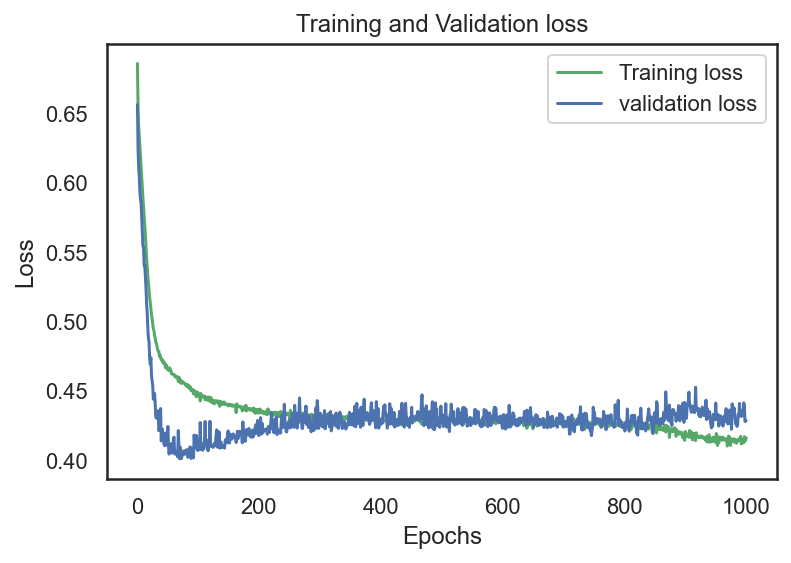

In [51]:
# Compute the ghaph for the loss.
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
print(epochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

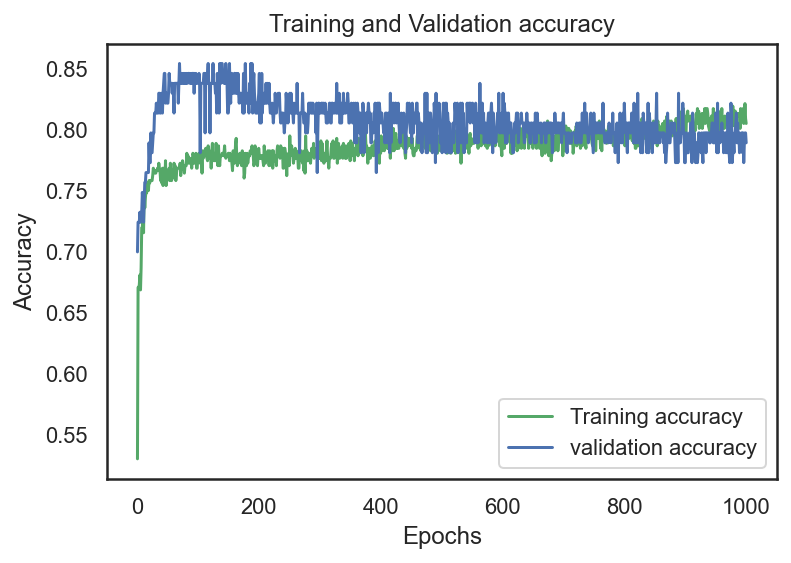

In [52]:
# Compute the ghaph for the loss.
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(acc_train) + 1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

----- ConfusionMatrixSklearn --------------
[[81 19]
 [12 42]]
----- Classification Report --------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       100
           1       0.69      0.78      0.73        54

    accuracy                           0.80       154
   macro avg       0.78      0.79      0.78       154
weighted avg       0.81      0.80      0.80       154

---- Confusion Matrix ---------------------


<function matplotlib.pyplot.show(close=None, block=None)>

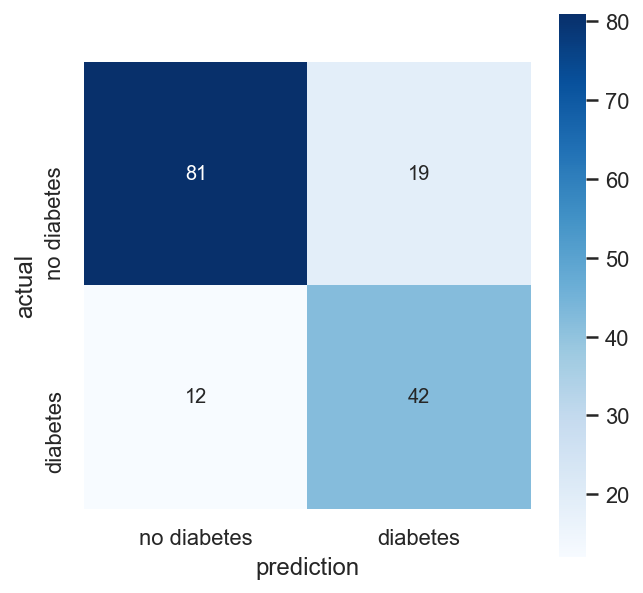

In [69]:
# Compute the Confusion Matrix.
from sklearn.metrics import confusion_matrix

treshold = 0.4

y_pred = model.predict(X_test)

# We turn the output of the model into classes.
y_pred[y_pred>=treshold] = 1
y_pred[y_pred<treshold] = 0

ConfusionMatrixSklearn = confusion_matrix(y_test,y_pred)

print('----- ConfusionMatrixSklearn --------------'); print(ConfusionMatrixSklearn)

Report = classification_report(y_test,y_pred)
print('----- Classification Report --------------'); print(Report)

print('---- Confusion Matrix ---------------------')
plt.figure(figsize = [5,5])
sns.heatmap(ConfusionMatrixSklearn, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['no diabetes', 'diabetes'],
           yticklabels=['no diabetes', 'diabetes']);
plt.xlabel('prediction')
plt.ylabel('actual')
plt.show

#### The f1-score is up to .8 using the simple MLP with 0.4 treshold.